In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import time
from IPython.display import display, Latex
import corner
import camb
from datetime import datetime
import h5py
import glob
import os
from scipy import signal


%matplotlib notebook 

## PROBLEM 1

We want to shift a function by an arbitrary amount by using a convolution. We know that in fourier space, 
the shifted version of a function is simply the multiplication of a phase ramp with the fourier transform of the original function (i.e. not shifted).
The phase ramp is defined as $\text{e}^{-2\pi i k \delta/N}$ where $\delta$ is the shift. Multiplying the ramp with the fourier transform of the original function and taking the inverse fourier transform of that returns the function shifted by amount $\delta$ which is, in other words, using a convolution to shift the function.

<IPython.core.display.Javascript object>


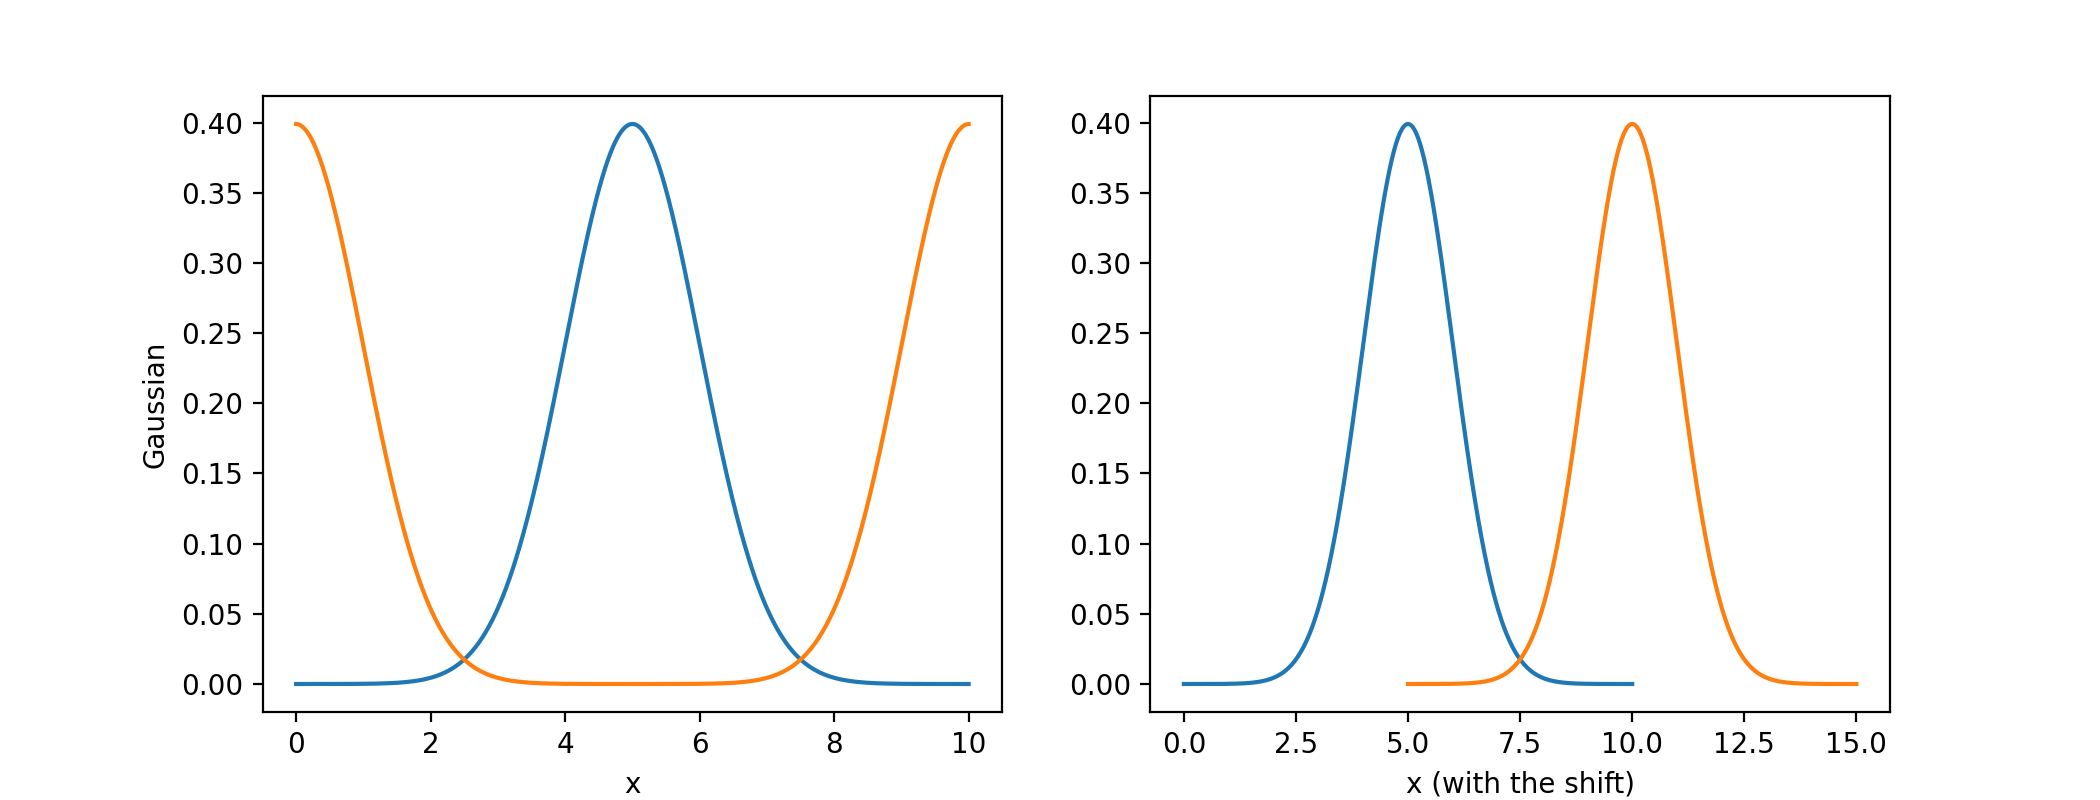

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [2]:
def shift_conv(array,shift):
    N = len(array)
    
    array_ft = np.fft.fft(array) #FT of original array
    k=np.arange(N) #frequency modes
    ramp = np.exp(-2*np.pi*1J*k*shift/N) #phase ramp with defined shift

    shift_ft = array_ft*ramp #multiply in fourier space
    shifted = np.fft.ifft(shift_ft) #inverse fourier transform (the result is the convolution)
    
    return shifted

def shift_conv_nowrap(array,shift):
    N = len(array)
    shifted = shift_conv(array,shift)
    tail = shifted[N//2:]
    head = shifted[:N//2]
    shifted[:N//2] = tail
    shifted[N//2:] = np.flip(head)
    
    return shifted
    
    
def gaussian(x,mu,std):
    return 1/(std*np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2/(2*std**2))


N=1000
start=0
end=10
x = np.linspace(start,end,N)
gauss = gaussian(x,np.median(x),1) #gaussian centered at the middle with std=1
shift = N/2 #shift by half array length
gauss_shift = shift_conv(gauss,shift)
freq = np.fft.fftfreq(N,x[1]-x[0])

fig,axs = plt.subplots(1,2)
axs[0].plot(x,gauss,label='Centered Gaussian')
axs[0].plot(x,gauss_shift,label='Shifted Gaussian by N/2')
axs[0].set_xlabel('x')
axs[0].set_ylabel('Gaussian')

#Because of the looping behavior of fourier transforms, we see the other of the shifted gaussian, shifted to head
#We can adjust the array to see the full version (code is not very neat but it's simply to have an idea)
xadj = np.linspace(end - shift*end/N,end + shift*end/N,N)
gauss_shiftadj=shift_conv_nowrap(gauss,shift)


axs[1].plot(x,gauss,label='Centered Gaussian')
axs[1].plot(xadj,gauss_shiftadj,label='Shifted Gaussian by N/2')
axs[1].set_xlabel('x (with the shift)')


fig.set_size_inches(10.5,4)

## PROBLEM 2 [a]

Below is a simple routine to compute the correlation of two functions. The correlation is given by

$f\star g = \text{IFT}\left[\text{DFT}(f)*\overline{\text{DFT}(g)}\right]$

<IPython.core.display.Javascript object>


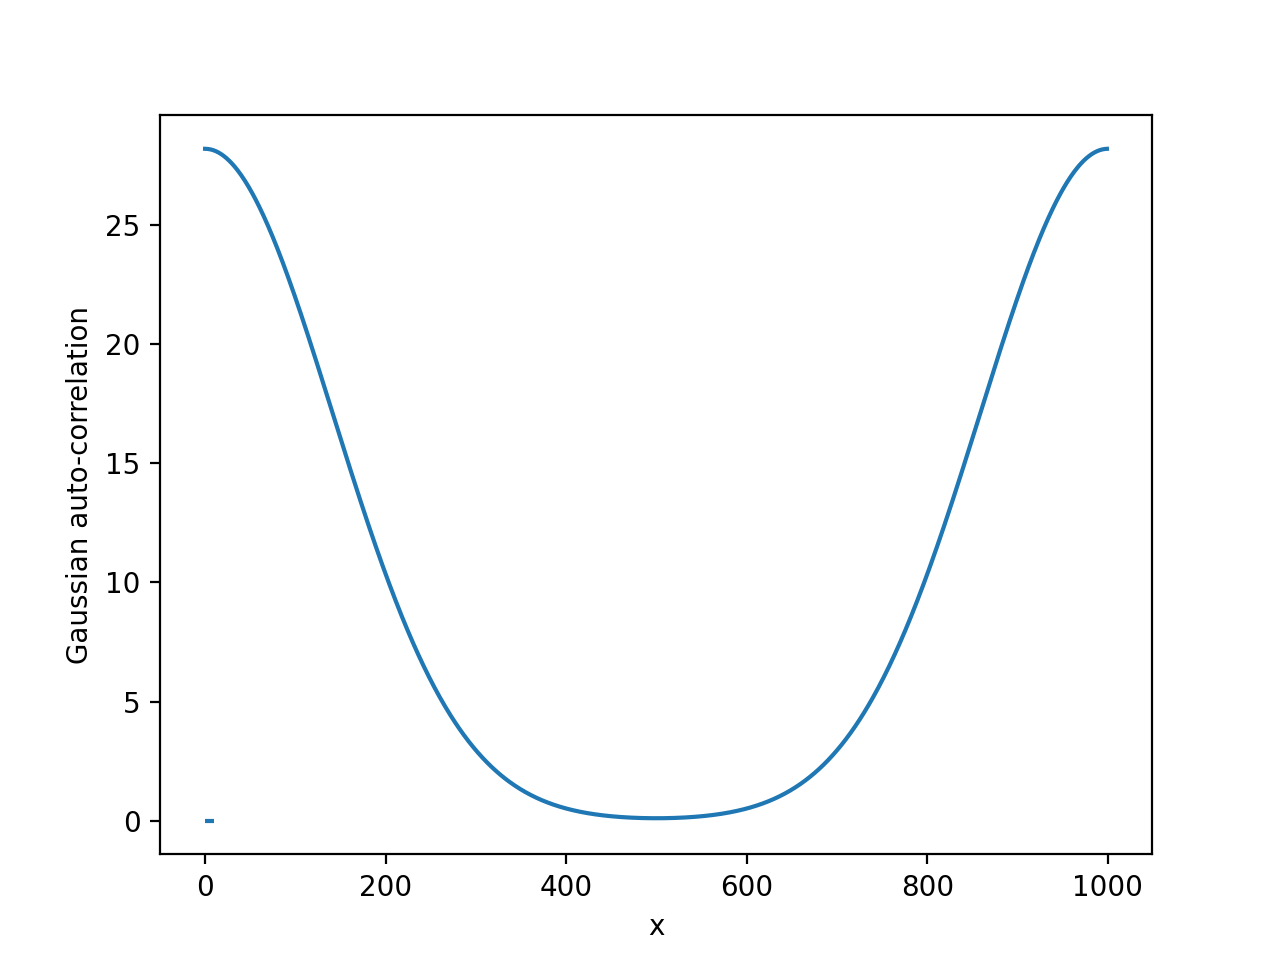

Text(0, 0.5, 'Gaussian auto-correlation')

In [3]:
def correlation(f,g):
    f_ft = np.fft.fft(f) #FT of f
    g_ft = np.fft.fft(g) #FT of g
    g_ft_cong  = np.conjugate(g_ft) #conjugate of FT(g)
    
    return np.fft.ifft(f_ft*g_ft_cong) #correlation function

#auto-correlation of a gaussian
gauss_autocorr  = correlation(gauss,gauss)

plt.figure()
plt.plot(gauss_autocorr)
plt.hlines(0,0,10)
plt.xlabel('x')
plt.ylabel('Gaussian auto-correlation')

This auto-correlation shape is expected as if we imagining computing the area of a copy of the gaussian moving to the right on the x-axis, we begin with maximum correlation as the two gaussians sit on top of each other, then a decrease down to zero at the right of $N/2$ (where there's is no overlap anymore) and then increasing again up to maximum correlation at N. This behaviour is again explained by the looping characteristic of fourier transforms, the fourier transform is symmetric on 0-$N/2$ and$N/2-N$.

## [b]

Redo [a] but correlated with a shifted version of itself.

<IPython.core.display.Javascript object>


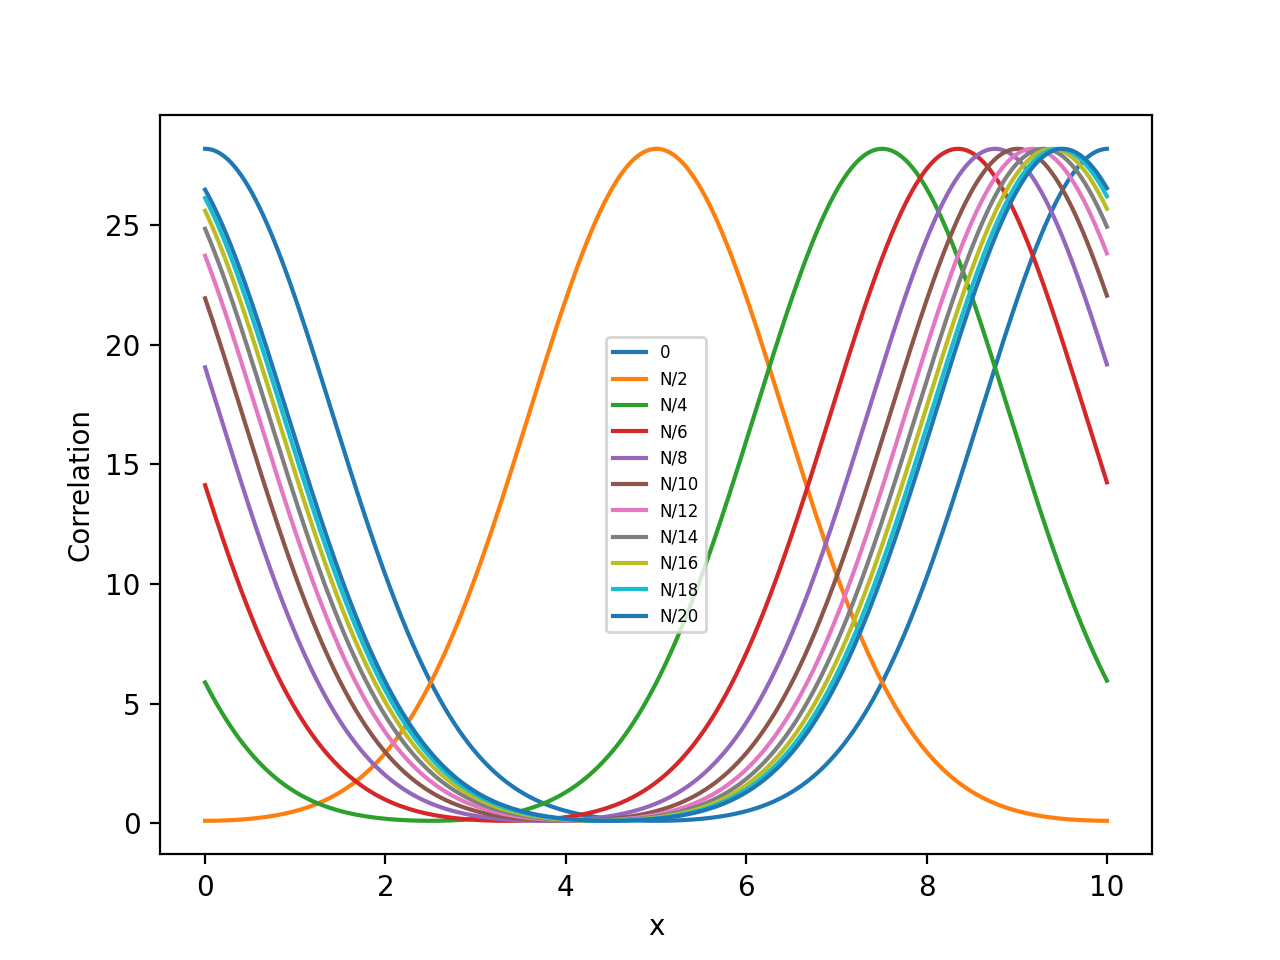

Text(0, 0.5, 'Correlation')

In [4]:
def auto_corr_shifted(f,shift):
    f_shifted = shift_conv(f,shift)
    return correlation(f,f_shifted)

shift = N/4
corr_shift = auto_corr_shifted(gauss,shift)

plt.figure()
for i in range(0,22,2):
    if i==0:
        shift=0
        shiftstr='0'
    else:
        shift = N//i
        shiftstr = 'N/' + str(i)
    corr_shift = auto_corr_shifted(gauss,shift)
    
    plt.plot(x,corr_shift,label=shiftstr)
    maxpos = shift

plt.legend(prop={'size': 6},loc='best')
plt.xlabel('x')
plt.ylabel('Correlation')

The correlation function depends on the shift in the manner that the maximum is where the overlap of the shifted and original gaussian occur (i.e. no longer at 0 and N as for the auto-correlation). For example, for a shift of N/2, we except the overlap to be at N/2 such that the maximum correlation will be at N/2 and this is what we observe. For a shift smaller than N/2, we except the overlap at N/4 (and N/4 + N/2 due to the looping). However, we should view the x-axis' range as -N/2 to N/2 instead of 0 to N/2 so this is why we see the max correlation at the right of N/2. 

## PROBLEM 3

We want to write a routine that takes a convolution of two functions without the danger of wrapping around. We know that the convolution theorem assumes the functions to be periodic and that the length of the arrays corresponds to one period. In fact, the convoluting function (f2) erroneously wraps around the two ends of the convoluted function (f1) so we need to modify the arrays to counter that.

I made a routine for two categories of function pairs that we want to convolute: 1) Signal and response arrays and 2) arbitrary functions.

For 1), I used the theory of in the manual (Numerical Recipes) to build the routine. Usually, a response function is smaller in length than the signal itself, so we need to extend it to the length of the signal (plus some zero padding). Also, we rearrange the response to be viewed as cyclic. In the manual, this is done by splitting the positive and negative duration of the signal. I wasn't sure how to split the response function when it is not symmetrical so I assumed for 1) that the pulse functions are symmetric and centered at the middle of the array. Although the code could be improved and generalized for other kind of pulses, I chose to only implement the code for symmetric and centered pulses because I simply wanted to try it and that 2) works all the time. So, I use a helper function that splits the response at the middle, put the second half at the head of the array and the first half, flipped, at the tail of the array and pads with zeros at the middle such that the response is extended with zeros and viewed as cyclic. Second, we extend the end of the signal with a pad of zeros of length half of the response. This way, if we convolute the padded signal and response functions and discard the irrelevant end we have an unspoiled convolution!

For 2), the principle is similar but takes more steps. Since we know the wrapping behaviour occurs for N//2, we pad with N zeros the head of one array and the tail of the other array. So, we have an unspoiled convolution with double size the length of our original array. We then shift the convolution array by N/2 and trim it to keep only the first half (i.e. up to N) of the convolution (originally of length 2N).

<IPython.core.display.Javascript object>


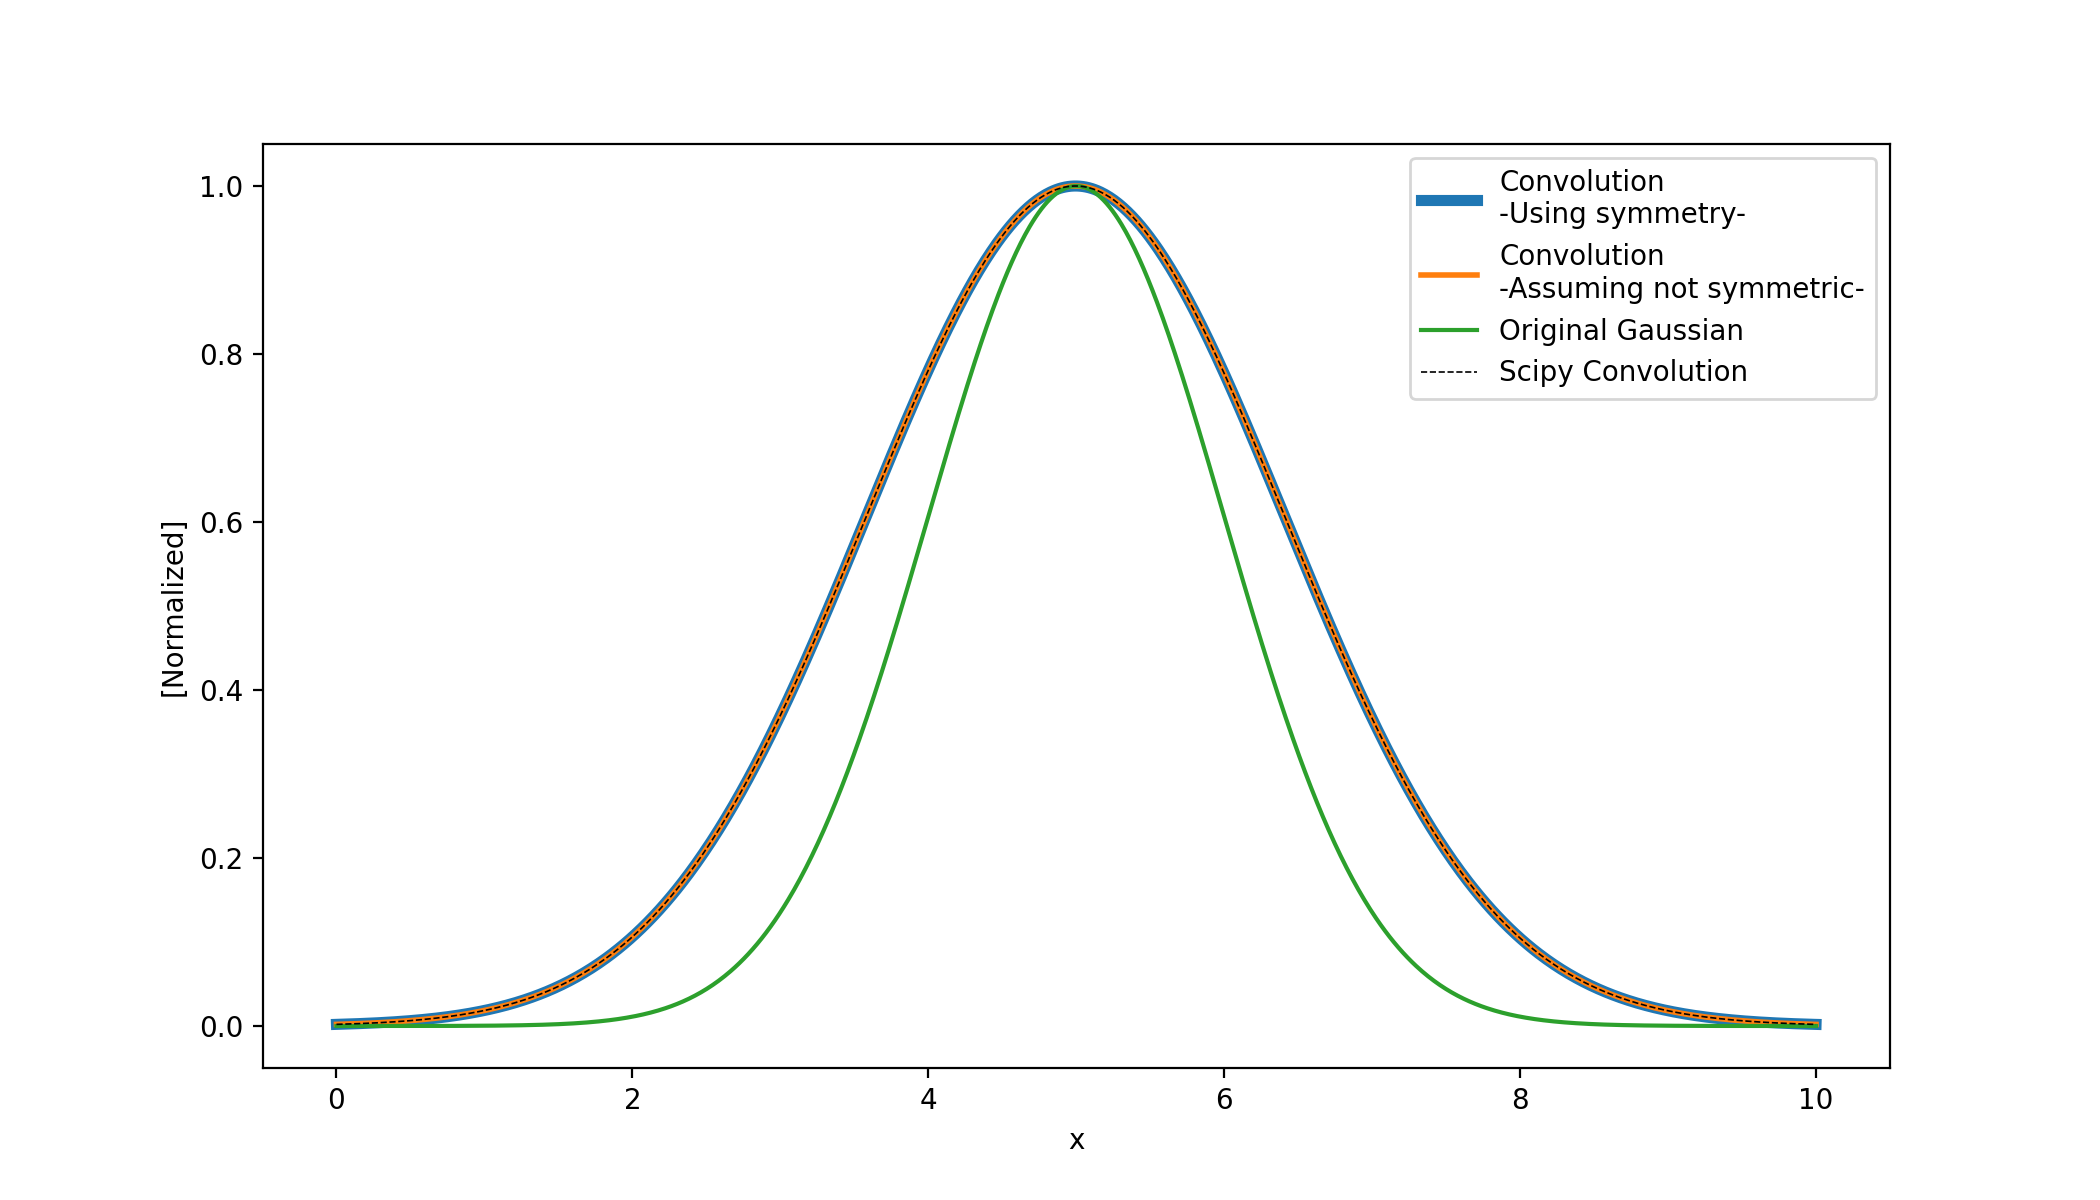

In [5]:
#response function as cyclic and extended
def cycl_resp(arr,n):
    #arr is the response array (in non-cyclic form)
    #n is the length of data array that we want to extend the response array to
    m=len(arr)
  
    resp=np.zeros(n)
    m_cur=0

    for i in range((n-m)//2,(n+m)//2): #center is the original response function
        resp[i] = arr[m_cur]
        m_cur += 1

    #rearrange the response to view it in a cyclic way
    head = resp[:n//2]
    tail = resp[n//2:]
    resp[:len(tail)]=tail
    resp[len(tail):]=np.flip(head)
    return resp


def antiwrap_conv(f1,f2,sym=False):
    #The default is sym set to False since this method works for all functions
    #We can use sym=True is the response (i.e. f2) is symmetric and centered at the middle of the array
    
    n = np.max((len(f1),len(f2)))
    shift=True #since the default is method 2), we assume that we need to shift the results at then end
    
    if not sym:
        #padding
        f1padded = np.zeros(2*n);f2padded = np.zeros(2*n)
        f1padded[:2*n-len(f1)]=f1
        f2padded[:2*n-len(f2)]=f2

    
    else:
        #f2 is a symmetric pulse
        #(we assume len(f2)<=len(f1))
        n=len(f1)
        m=len(f2)

        #f2 --> array extended and viewed as cylic
        f2padded = cycl_resp(f2,n+m//2)

        #padd with zeros the end of f1 array
        f1padded = np.zeros(n+m//2)
        f1padded[:n] = f1
        
        shift=False #we don't need to shift with this method
    
    f1_fft = np.fft.fft(f1padded) #take the fourier transforms
    f2_fft = np.fft.fft(f2padded) 
    
    conv = np.fft.ifft(f1_fft*f2_fft) #take the inverse fourier == convolution
    
    if shift:
        conv = shift_conv_nowrap(conv,n/2)
    
    return conv[:n] #discard what is irrelevant after n
        
        


N=1000
start=0
end=10
x = np.linspace(start,end,N)
gauss = gaussian(x,np.median(x),1) #gaussian centered at the middle with std=1
conv = antiwrap_conv(gauss,gauss) #assuming not symmetric
conv2 = antiwrap_conv(gauss,gauss,True) #knowing it is symmetric

true = signal.fftconvolve(gauss,gauss)[500:1500]

fig = plt.figure()
plt.plot(x,conv2/conv2.max(),linewidth = 4, label='Convolution\n-Using symmetry-')
plt.plot(x,conv/conv.max(),linewidth = 2, label='Convolution\n-Assuming not symmetric-')
plt.plot(x,gauss/gauss.max(),label='Original Gaussian')
plt.plot(x,true/true.max(),linewidth = 0.6, linestyle = '--', color='k',label='Scipy Convolution')
plt.legend()
plt.xlabel('x')
plt.ylabel('[Normalized]')
fig.set_size_inches(10.5,6)




<IPython.core.display.Javascript object>


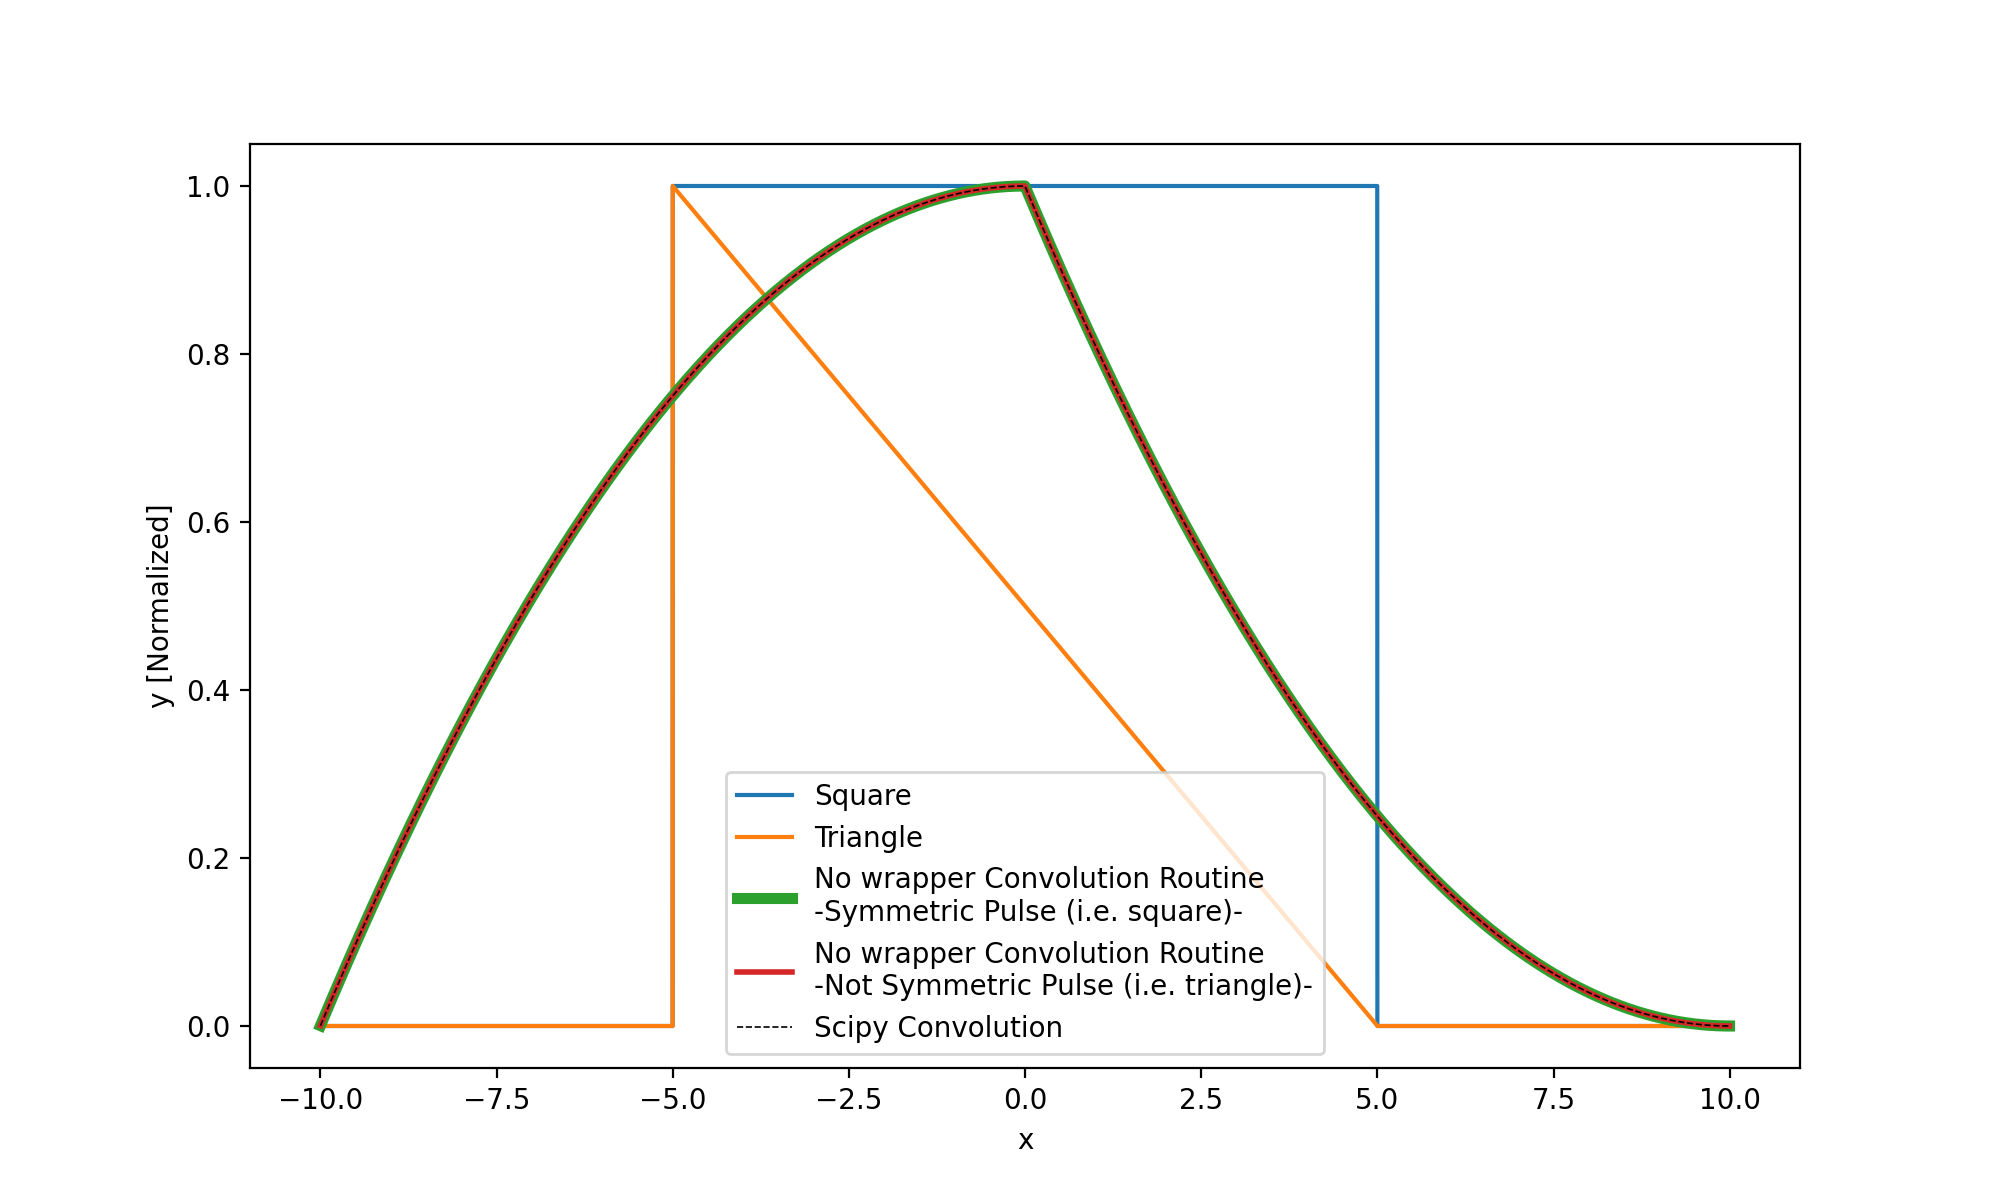

In [6]:
#second classic example with the square and triangle (that we often come across when learning convolution):

#make a square and a triangle
N=10000
x = np.linspace(-10,10,N+1)
indneg = np.where(x==-5)[0][0]; indplus = np.where(x==5)[0][0]

square = np.zeros(N)
square[indneg:indplus] = 1

triangle = np.zeros(N)
for i in range(indneg,indplus+1):
    triangle[i] = 1/2 - 1/10*x[i]

#convolute
convu = antiwrap_conv(triangle,square)
convu2 = antiwrap_conv(square,triangle)
true = signal.fftconvolve(triangle,square)

fig = plt.figure()
plt.plot(x[:N],square,label='Square')
plt.plot(x[:N],triangle,label='Triangle')
plt.plot(x[:N],convu/convu.max(),linewidth = 4,label='No wrapper Convolution Routine\n-Symmetric Pulse (i.e. square)-')
plt.plot(x[:N],convu2/convu2.max(),linewidth = 2,label='No wrapper Convolution Routine\n-Not Symmetric Pulse (i.e. triangle)-')
plt.plot(x[:N],true[N//2:N*3//2]/true.max(),linestyle='--',linewidth='0.6',color='k',label='Scipy Convolution')
plt.legend()
plt.xlabel('x')
plt.ylabel('y [Normalized]')
fig.set_size_inches(10,6)

## Problem 4

## [a]
We want to show that (note that the sum is taken from x=0 to N-1)

$\sum \text{e}^{-2\pi ikx/N} = \frac{1-\text{e}^{-2\pi ikx}}{1-\text{e}^{-2\pi ikx/N}}$

We know this has the form of a geometric series since $|\text{e}^{-2\pi ik/N}|=r \leq 0$. Define $\sum \text{e}^{-2\pi ikx/N}$ as $s_n$, we have

$s_n = r^0 + r^1 + ... + r^{N-1}$

$rs_n = r^1 + r^2 + ... + r^{N}$

$\implies s_n - rs_n = s_n(1-r) = r^0 - r^{N} = 1 - r^{N} \implies s_n = \frac{1 - r^{N}}{1-r}$

So $s_n = \sum \text{e}^{-2\pi ikx/N} = \frac{1 - r^{N}}{1-r} = \frac{1-\text{e}^{-2\pi ikx}}{1-\text{e}^{-2\pi ikx/N}}$ Hence proven.

## [b]
To show that this goes to $N$ as $k$ goes to 0, we simply take the limit of $\frac{1-\text{e}^{-2\pi ikx}}{1-\text{e}^{-2\pi ikx/N}}$ as $k$ goes to 0.

$\lim_{k\rightarrow0} \frac{1-\text{e}^{-2\pi ikx}}{1-\text{e}^{-2\pi ikx/N}} = *\frac{0}{0} \rightarrow \text{use L'Hospital}* = \frac{2\pi i\text{e}^{-2\pi ikx}}{2\pi i/N\text{e}^{-2\pi ikx/N}} = \frac{2\pi i}{2\pi i/N} = N$, hence shown.



If we take the top, by Euler's formula,
$1-\text{e}^{-2\pi ik} = 1 - cos(-2\pi k)-isin(-2\pi k) = 1 - cos(2\pi k)+isin(2\pi k)$
We know $cos(2\pi k) = 1$ for any integer $k$ and $sin(2\pi k)=0$ for any integer $k$ so we have $1-\text{e}^{-2\pi ikx} = 1 - 1 + 0 = 0$

Now, for the denominator, $1-\text{e}^{-2\pi ik/N} = 1 - cos(2\pi k/N) + isin(-2\pi k/N)$, if $k/N$ is not an integer (i.e. $k$ not a multiple of $N$), then $1 - cos(2\pi k/N) + isin(-2\pi k/N) \neq 0$ so we have 

$\frac{1-\text{e}^{-2\pi ikx}}{1-\text{e}^{-2\pi ikx/N}} = \frac{0}{\text{something}} = 0$




## [c]

We use the formula above to analytically find the DFT of a non-integer sine wave. We want to find

$F(k) = \sum sin(kx)\text{e}^{-2\pi i k x/N}$, By Euler, $ =\sum \left(\frac{\text{e}^{(ik-2\pi i k'/N)x}-\text{e}^{-(ik-2\pi i k'/N)x}}{2i}\right)$

which by the analytical form above gives,

$F(k)=\frac{1}{2i}\left(\frac{1-\text{e}^{(ikN-2\pi i k')}}{1-\text{e}^{(ik-2\pi i k'/N)}} - \frac{1-\text{e}^{-(ikN-2\pi i k')}}{1-\text{e}^{-(ik-2\pi i k'/N)}})\right)$

<IPython.core.display.Javascript object>


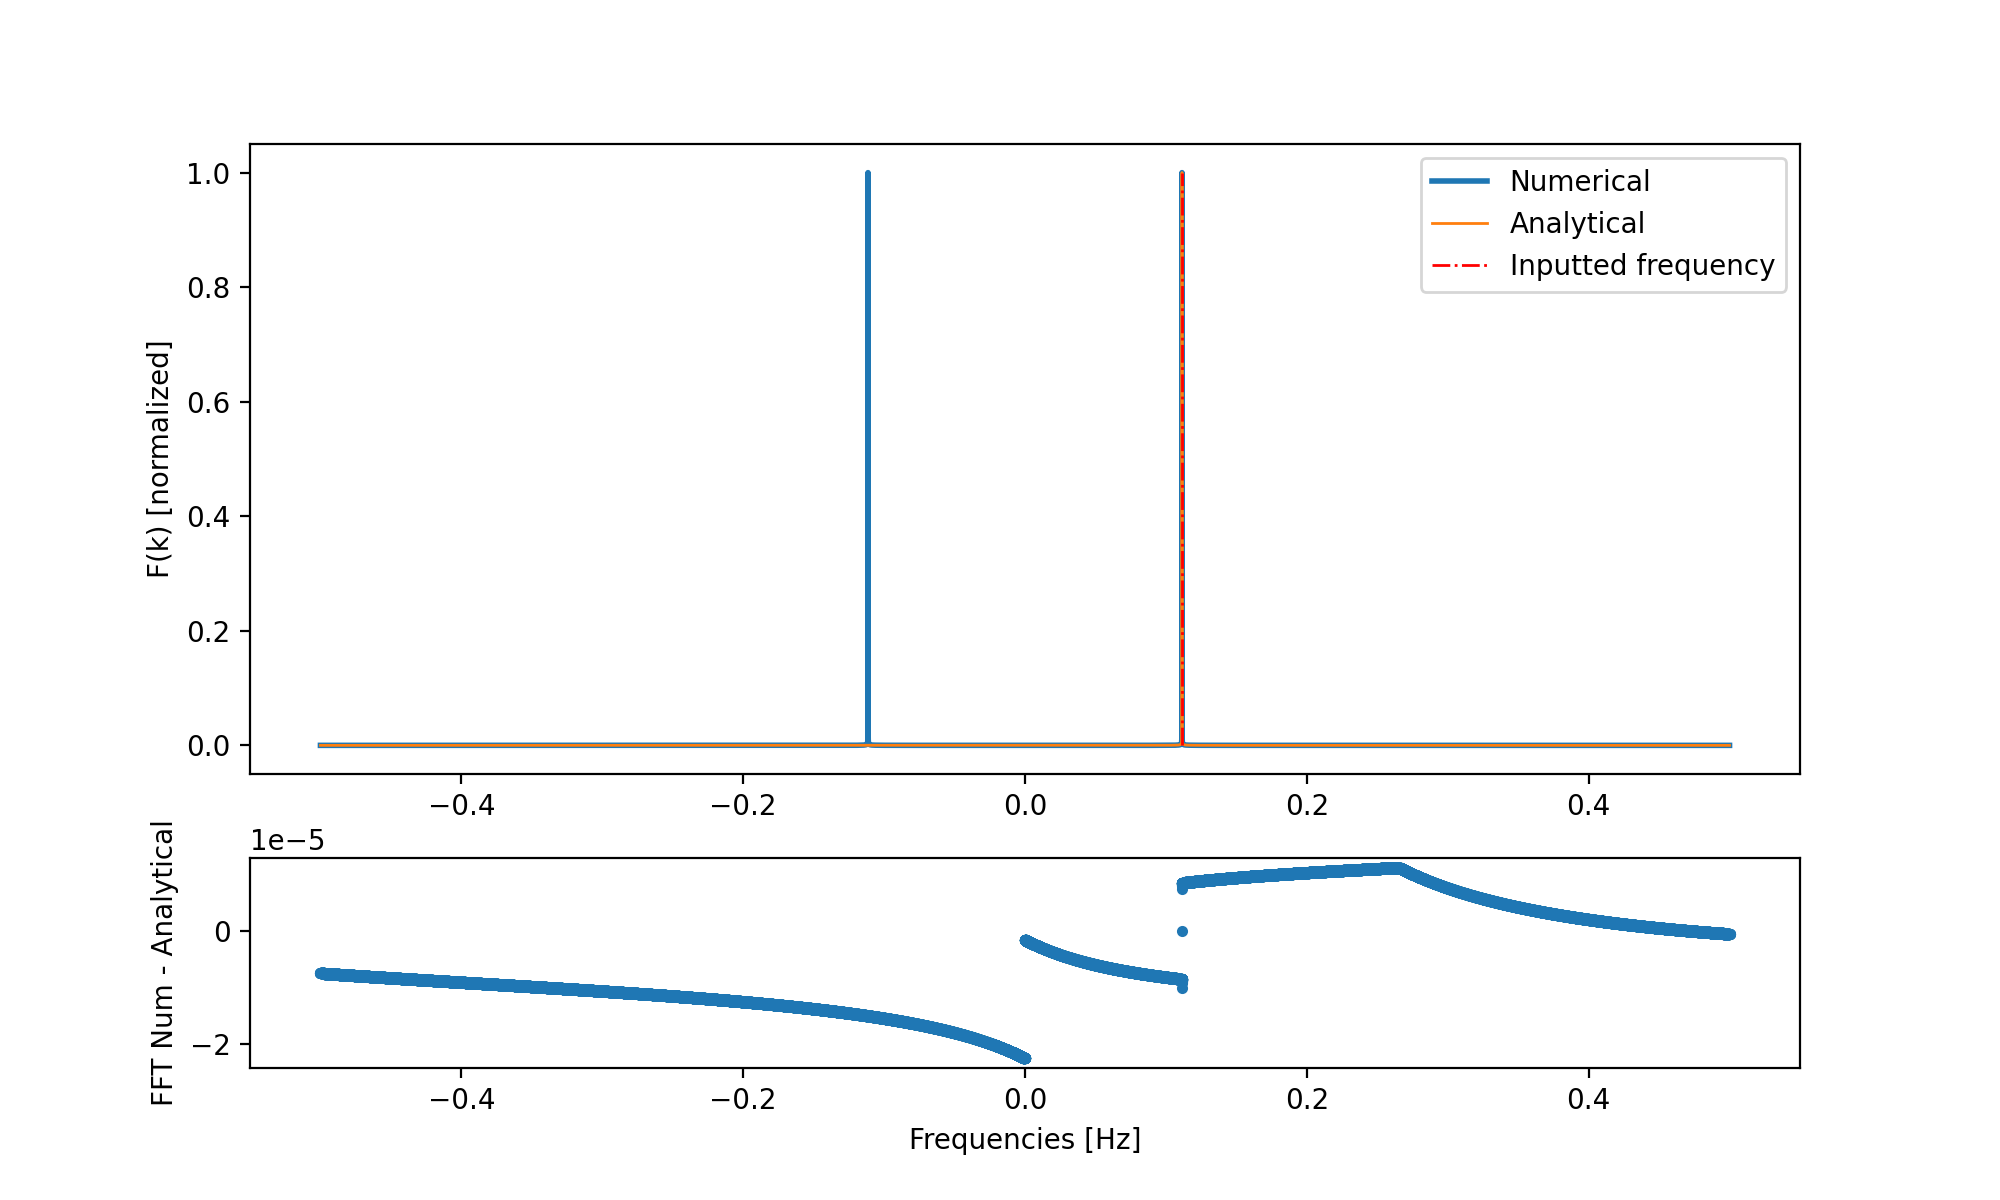

In [7]:
def analytical_sindft(k,N): #analytical Fourier Transform for sin(kx)
    k2 = np.arange(N)
    term1 = (1-np.exp((k-2*np.pi*k2/N)*1J*N))/(1-np.exp((k-2*np.pi*k2/N)*1J))
    term2 = np.conjugate(term1)
    Fk = np.abs(1/2J*(term1-term2))
    
    return Fk




k=0.7 # pick a non-integer input signal k
f=k/(2*np.pi) #absolute freq (Hz)
N=100000

x = np.arange(N)
y_sin = np.sin(k*x)

sin_dft_ana = analytical_sindft(k,N) #analytical result

sin_dft_num = np.fft.fft(y_sin) #FFT results over N (i.e. number of samples)
freq = np.fft.fftfreq(N,x[1]-x[0]) #x[1]-x[0] is the sample spacing --> returns the corresponding frequencies
sin_dft_num = np.abs(np.fft.fftshift(sin_dft_num)) #swaping the half spaces such that the 0 freq is at center
sin_dft_ana = np.fft.fftshift(sin_dft_ana)
freq = np.fft.fftshift(freq)



fig,axs = plt.subplots(2,gridspec_kw={'height_ratios':[3,1]})
axs[0].plot(freq,sin_dft_num/sin_dft_num.max(), linewidth = 2, label='Numerical')
axs[0].plot(freq,sin_dft_ana/sin_dft_ana.max(), linewidth = 1,label='Analytical')
ylims = plt.gca().get_ylim()
axs[0].vlines(f,ylims[0],ylims[1],linestyle='dashdot',color='r',linewidth=1,label='Inputted frequency')
axs[0].legend()
axs[0].set_ylabel('F(k) [normalized]')

sin_dft_num_pos = sin_dft_num.copy()
sin_dft_num_pos[freq<0]=0

axs[1].plot(freq,np.abs(sin_dft_num_pos)/np.max(np.abs(sin_dft_num_pos))-sin_dft_ana/np.max(sin_dft_ana),'.')
axs[1].set_ylabel('FFT Num - Analytical')
axs[1].set_xlabel('Frequencies [Hz]')

fig.set_size_inches(10,6)

We see that the FFT agrees with the analytical estimate by the plot shown above. The peaks resemble to a delta function but we see that we do not exactly get that and could be closer to one.

## [d] Window 

Because we have a sharp edge at the end of the interval, we should use a window function which goes to zero at the edges to prevent the leakage. We can use the function $\frac{1}{2} - \frac{1}{2}cos(2\pi x/N)$ as the window.


<IPython.core.display.Javascript object>


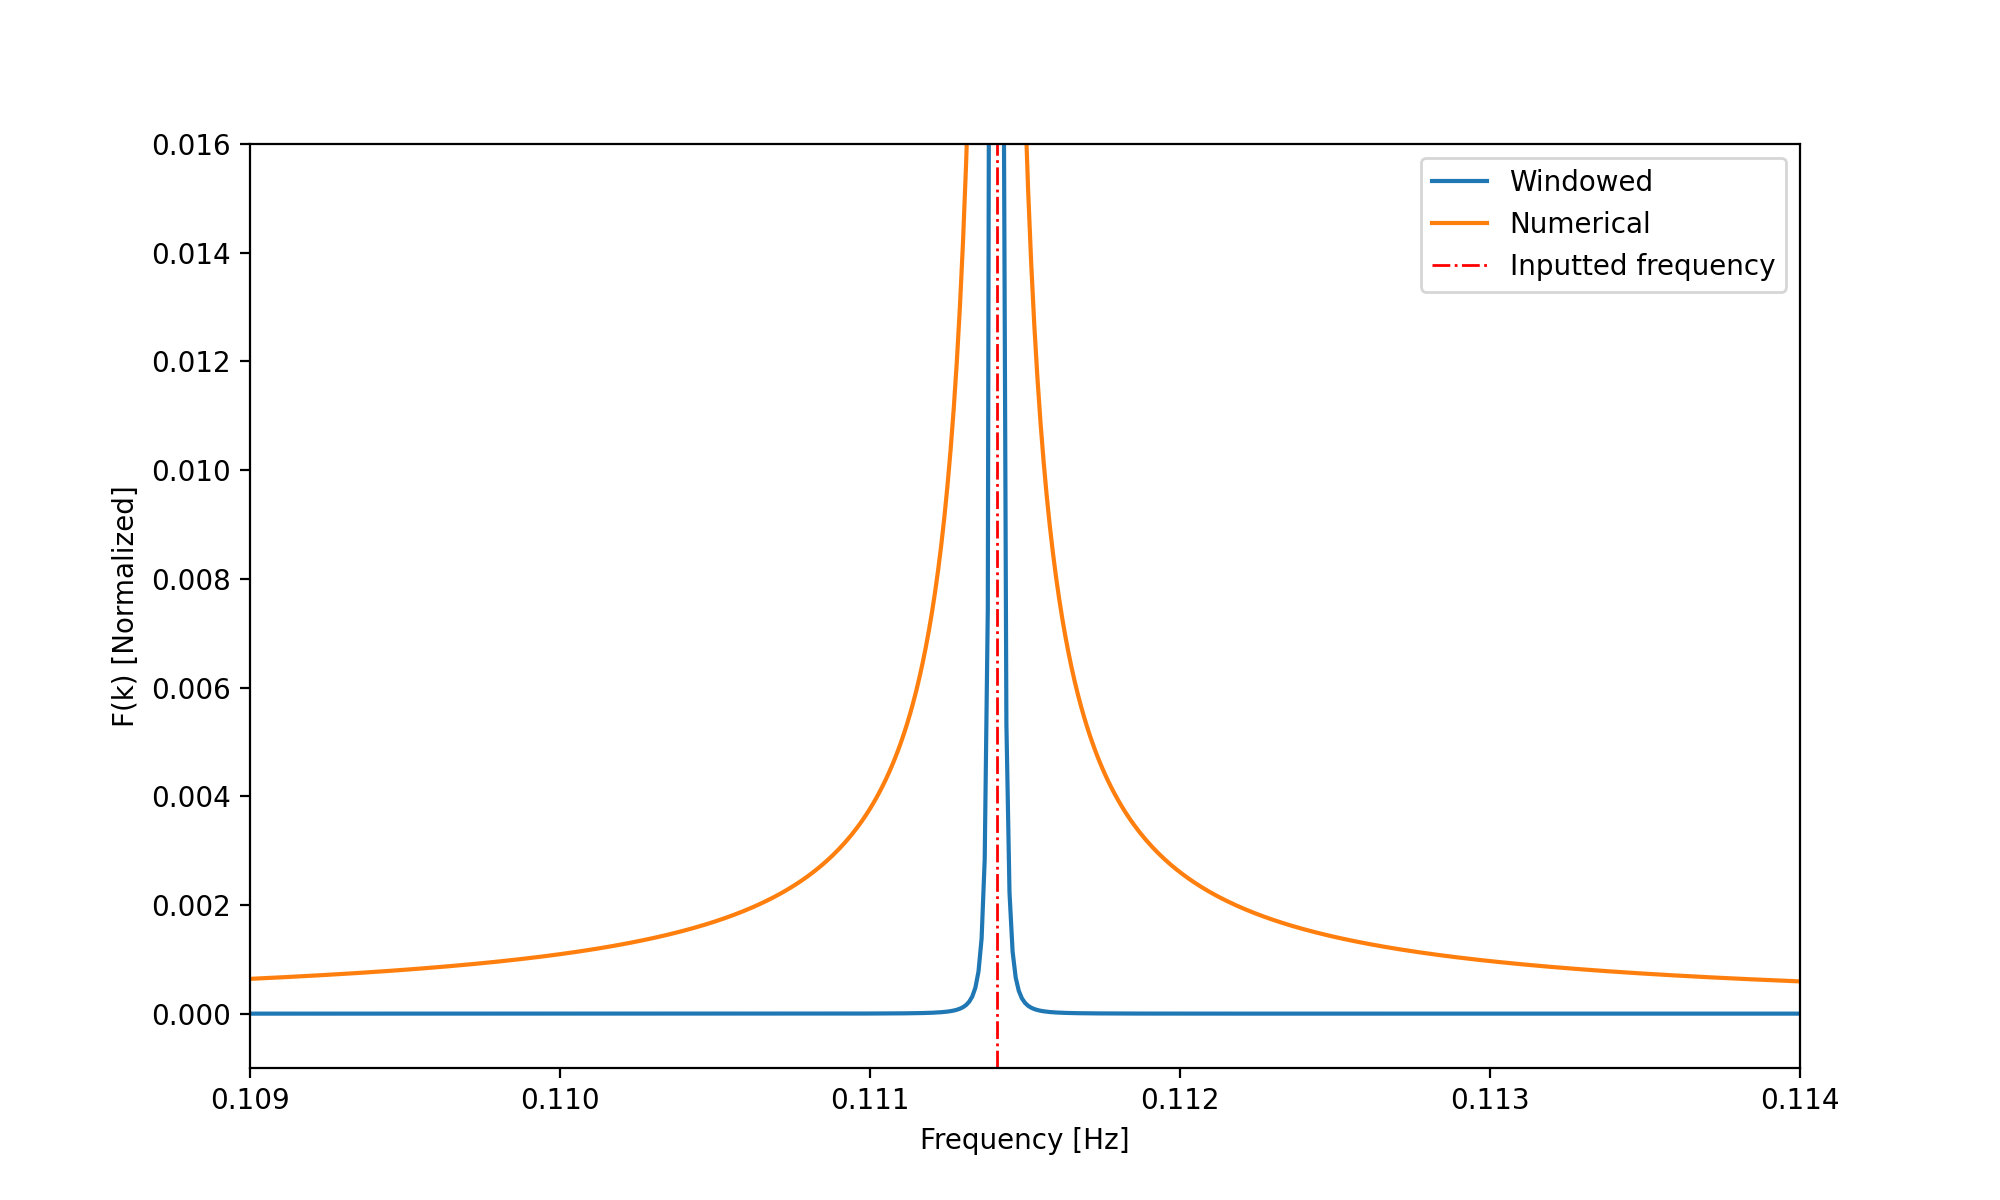

In [8]:
win = 0.5 - 0.5*np.cos(2*np.pi*x/N) #window

#multiply in real space, convolve in Fourier space
windowed = np.fft.fft(win*y_sin)
windowed_sh = np.abs(np.fft.fftshift(windowed))

fig = plt.figure()
plt.plot(freq,windowed_sh/windowed_sh.max(),label='Windowed')
plt.plot(freq,sin_dft_num/sin_dft_num.max(),label='Numerical')
ylims = [-0.001,0.016]
xlims = [0.109,0.114]
plt.vlines(f,ylims[0],ylims[1],linestyle='dashdot',color='r',linewidth=1,label='Inputted frequency')
plt.ylim(ylims)
plt.xlim(xlims)
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('F(k) [Normalized]')
fig.set_size_inches(10,6)

By the above figure, we see that the spectral leakage for a non-integer period sine wave drops dramatically.

## [e] Fourier Transform of the window

We can derive the fourier transform of the window as follows,

$F(k) = \sum (\frac{1}{2} - \frac{1}{2}cos(2\pi x/N) \text{e}^{-2\pi i k x/N}) = \sum \frac{1}{2}\text{e}^{-2\pi i k x/N} - \sum \frac{1}{4}\left(\text{e}^{-2\pi i/N (k-1)x} + \text{e}^{-2\pi i/N (k+1)x}\right) = \frac{N}{2}\delta(k) -\frac{N}{4}\delta(k-1) - \frac{N}{4}\delta(k+1)$

Since $k=-1$ is the same as $k=N$ by the periodicity of fourier transform we thus have [$\frac{N}{2}$,-$\frac{N}{4}$,$0$,$0$,...,$0$,-$\frac{N}{4}$] or if we shift the frequencies to be centered at $0$ (i.e. from -$\frac{N}{2}$ to $\frac{N}{2}$) we have [$0$,$0$,...,$0$,-$\frac{N}{4}$,$\frac{N}{2}$,-$\frac{N}{4}$,$0$,$0$,...,$0$] which can be seen on the following plot.

<IPython.core.display.Javascript object>


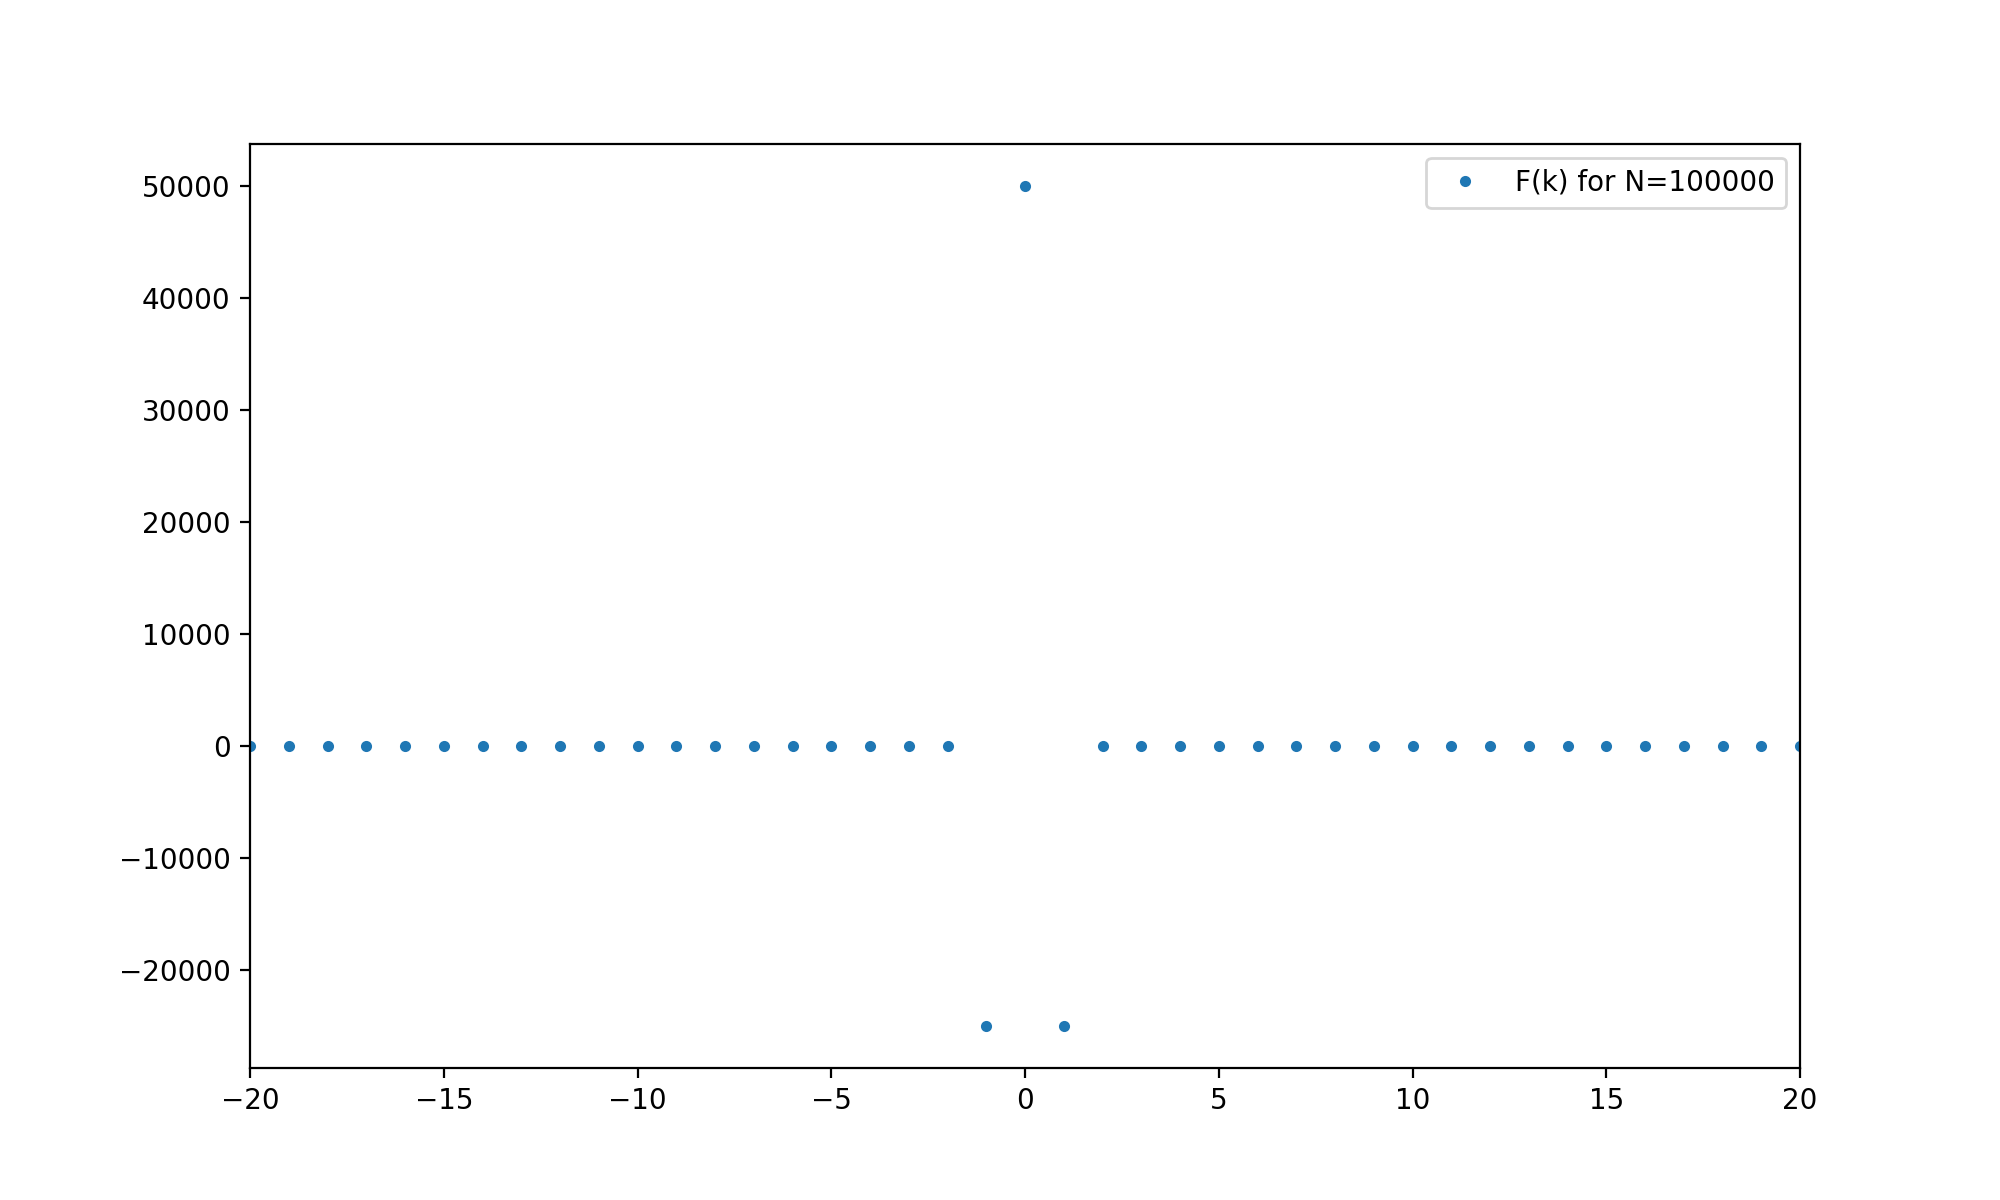

In [9]:
window_ft = np.fft.fft(win)
x = np.arange(start=-N/2,stop=N/2,step=1)
window_ft_shift = np.fft.fftshift(window_ft)

fig = plt.figure()
lab='F(k) for N=' + str(N)
plt.plot(x,window_ft_shift,'.',label=lab)
plt.xlim([-20,20])
plt.legend()
fig.set_size_inches(10,6)


Indeed, we observe what we expected as can be seen on the plot shown above.

Now, since we are convoluting in frequency space, taking the convolution of the window and the function in the frequency domain is like taking the area under the function and weight it by the window. Since we have that the fourier transform of our window is given by [0,...,0,-$\frac{N}{4}$,$\frac{N}{2}$,-$\frac{N}{4}$,0...,0], we can use that to weight the function. For every points, we do a weighted average with the preceding and successing points (with -N/4, N/2 and -N/4) of the fourier transform.

* Note that for the boundaries, i.e. first and last point of the array, we can simply use the last (first) point of the array as the preceding (successing) point when we average the first (last) point since the fourier transform is cyclic!




<IPython.core.display.Javascript object>


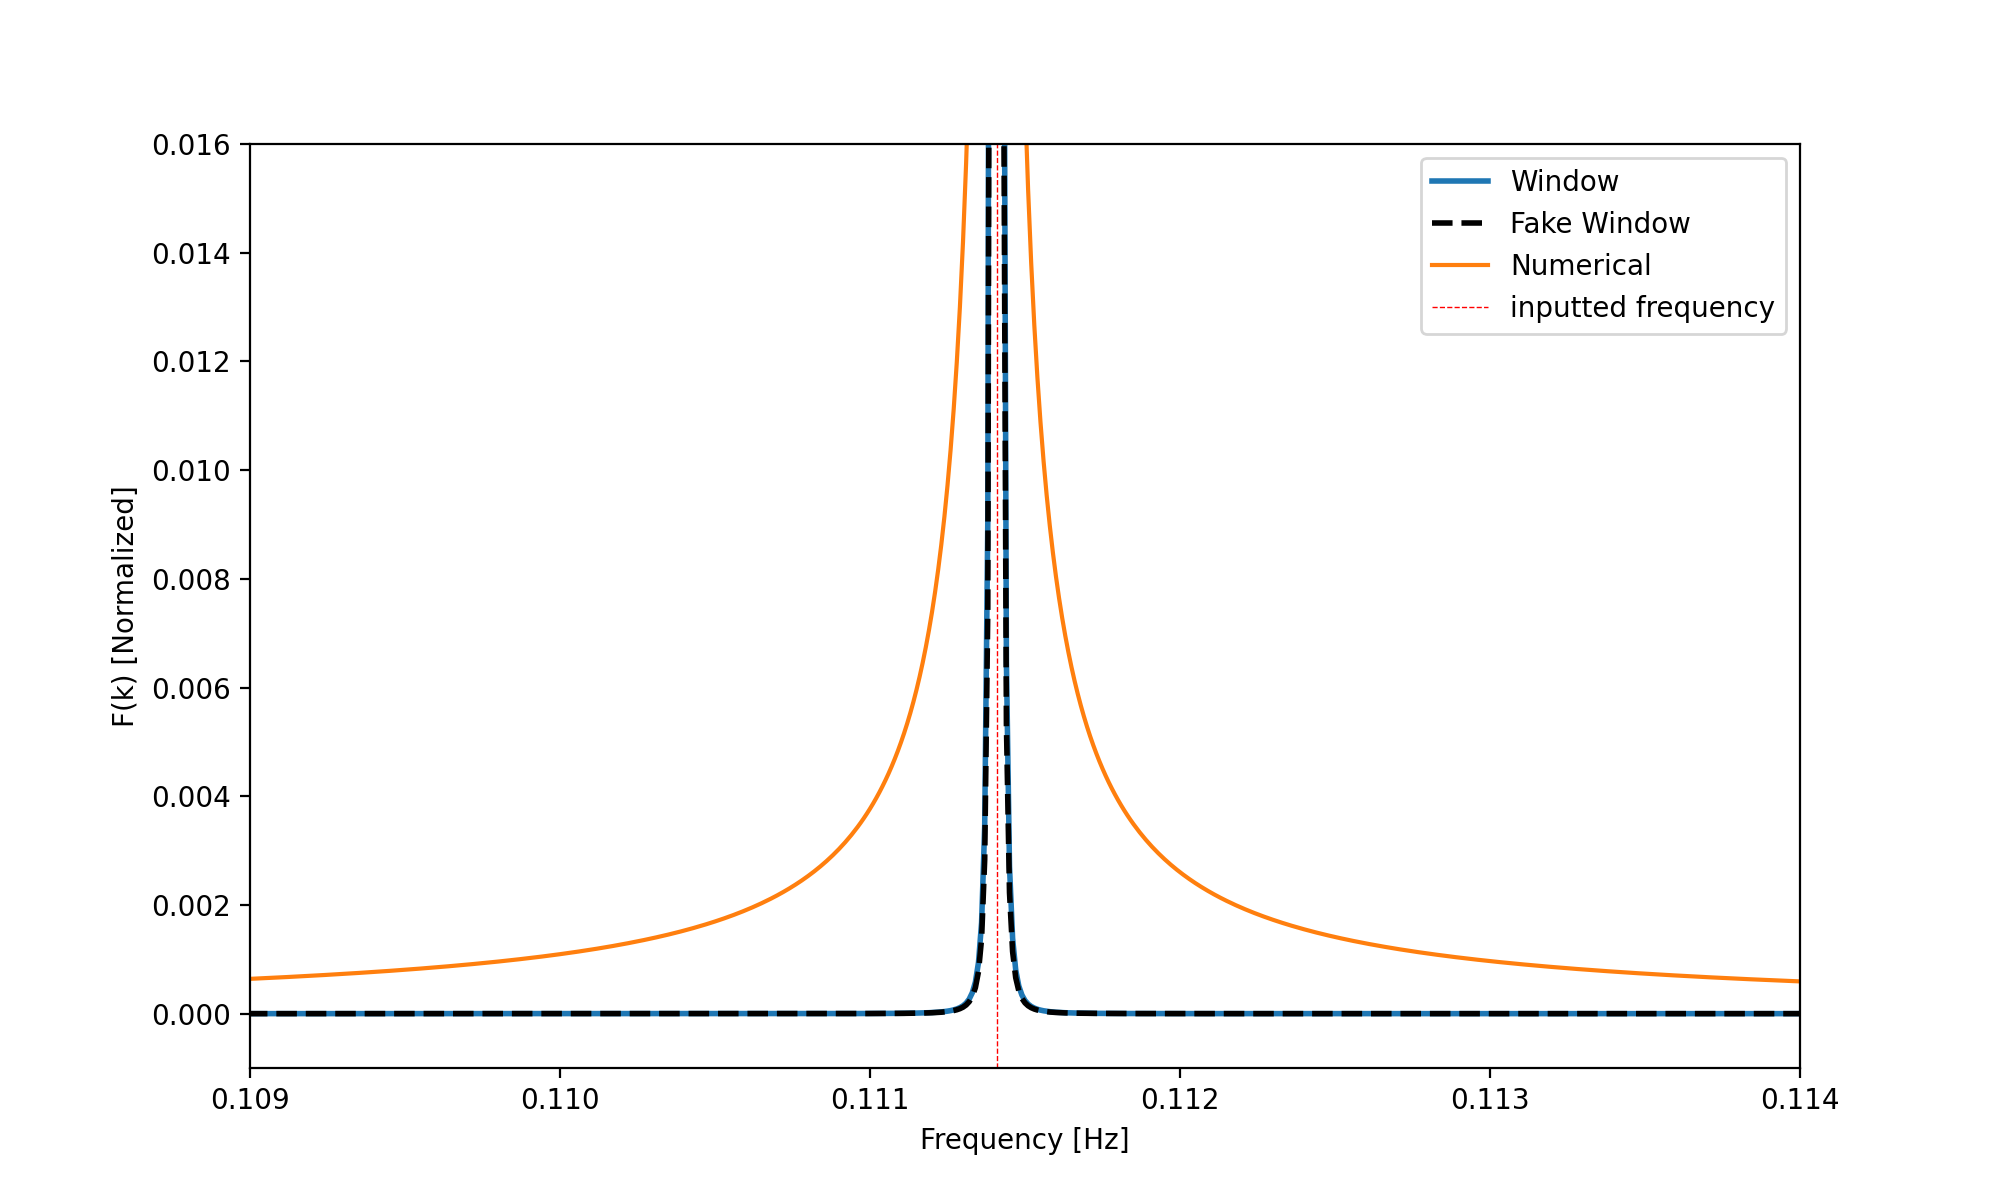

In [10]:
def fake_window(function): #faking the use of window by appropriately combining unwindowed FT of a function
    weighted_func = function.copy()
    for i in range(len(function)):
        if i==0:
            weighted_func[i] = function[-1]*(-0.25)+function[i]*0.5+function[i+1]*(-0.25) #weighted avg
        elif i==(len(function)-1):
            weighted_func[i] = function[i-1]*(-0.25)+function[i]*0.5+function[0]*(-0.25) #weighted avg
        else:
            weighted_func[i] = function[i-1]*(-0.25)+function[i]*0.5+function[i+1]*(-0.25) #weighted avg
    return weighted_func

faked_win = fake_window(sin_dft_num)

fig = plt.figure()
plt.plot(freq,np.abs((faked_win))/np.abs(faked_win).max(),label='Window',linewidth=2)
plt.plot(freq,windowed_sh/windowed_sh.max(),label='Fake Window',linewidth=2,linestyle='--',color='k')
plt.plot(freq,np.abs(sin_dft_num)/np.abs(sin_dft_num).max(),label='Numerical')
plt.axvline(f,label='inputted frequency',color='r',linestyle='--',linewidth=0.5)
plt.xlim(xlims)
plt.ylim(ylims)
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('F(k) [Normalized]')
fig.set_size_inches(10,6)


Indeed we see that the "fake window" method matches with using the window on the function!

## MATCHED FILTER OF LIGO DATA

## PROBLEM 5

We want to find a signal in a very noisy dataset so we use a least-squares fit to find the best amplitude, where a template is used which describes how the signal should look like and we apply tricks to whiten the noise.

The maximum likelihood of $m$, where $m$ is the best fit amplitude of the signal, is given (from the least-squares fit) by

$A^TN^{-1}A m = A^T N^{-1}d$, where $A$ is our template, $N$ is the noise matrix and $d$ the data. We can rewrite this as

$A^TN^{-1/2}*N^{-1/2}Am = A^TN^{-1/2}*N^{-1/2}d$

$(N^{-1/2}A)^T*(N^{-1/2}A) m = (N^{-1/2}A)^T * (N^{-1/2}d)$ So, for a template centered at time $\tau$ we have that the amplitude for the signal occuring at time $\tau$ is 

$m(\tau) = (N^{-1/2}A(t-\tau))^T * (N^{-1/2}d) / (N^{-1/2}A((t-\tau))^T*(N^{-1/2}A((t-\tau))$. Let the denominator be called the Hessian, $H$. If we only care for the time at which the signal occurs, then we can ignore $H$ since the noise is stationary such that $H$ is constant and define our matched filter as such:

$mf = (N^{-1/2}A(t-\tau))^T * (N^{-1/2}d) = A_{\text{filtered}}(t-\tau)^T*d_{\text{filtered}}(t)$. Since this is a cross-correlation we can switch to Fourier space for ease of calculations! Note that we use need to use windows on the template and the data to avoid craziness due to the edges. 

So we have that our matched filter is $IFT (\text{conj}(\tilde{A_{\text{filtered}}})\tilde{d_{\text{filtered}}})$!



In [11]:
#Jon's read_template function to get the ligo data
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    tp=template[0]
    tx=template[1]
    return tp,tx
def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    gpsStart=meta['GPSstart'][()]
    utc=meta['UTCstart'][()]
    duration=meta['Duration'][()]
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc


In [12]:
class Event: #defining class event just to make the code more clear
    def __init__(self,strain,dt,utc):
        self.strain = np.array(strain)
        self.dt = np.array(dt)
        self.utc = np.array(utc)
    
    def get_ps(self,window=1): #power spectrum, option to convolute with window (if default --> no window)
        return np.abs(np.fft.rfft(window*self.strain))**2
        
class Template: #defining class event just to make the code more clear
    def __init__(self,tp,tx):
        self.tp = np.array(tp)
        self.tx = np.array(tx)
    
    def get_ps(self,window=1):
        return np.abs(np.fft.rfft(window*self.tp))**2
        
os.chdir('./EVENTS_FOLDER')
fnamesH=glob.glob("H-*.hdf5") #Hanford detector events
fnamesL=glob.glob("L-*.hdf5") #Livingston detector events

events = dict()
for i in range(len(fnamesH)): #define the events, first 4 in the dict are Hanford, last four are Livingston
    print('reading event file ',fnamesH[i])
    strain,dt,utc=read_file(fnamesH[i])
    events[i] = Event(strain,dt,utc)
for i in range(len(fnamesL)):
    print('reading event file ',fnamesL[i])
    strain,dt,utc=read_file(fnamesL[i])
    events[i+len(fnamesH)] = Event(strain,dt,utc)    

os.chdir('..')

os.chdir('./TEMPLATES_FOLDER')
fnames=glob.glob("[GL]*.hdf5")
templates = dict()
for i in range(len(fnames)): #define the templates
    print('reading template file ',fnames[i])
    tp,tx=read_template(fnames[i])
    templates[i] = Template(tp,tx)

os.chdir('..')

reading event file  H-H1_LOSC_4_V2-1135136334-32.hdf5
reading event file  H-H1_LOSC_4_V2-1128678884-32.hdf5
reading event file  H-H1_LOSC_4_V2-1126259446-32.hdf5
reading event file  H-H1_LOSC_4_V1-1167559920-32.hdf5
reading event file  L-L1_LOSC_4_V2-1135136334-32.hdf5
reading event file  L-L1_LOSC_4_V2-1128678884-32.hdf5
reading event file  L-L1_LOSC_4_V2-1126259446-32.hdf5
reading event file  L-L1_LOSC_4_V1-1167559920-32.hdf5
reading template file  GW150914_4_template.hdf5
reading template file  GW151226_4_template.hdf5
reading template file  LVT151012_4_template.hdf5
reading template file  GW170104_4_template.hdf5


Let's first look at the data and the templates:

<IPython.core.display.Javascript object>


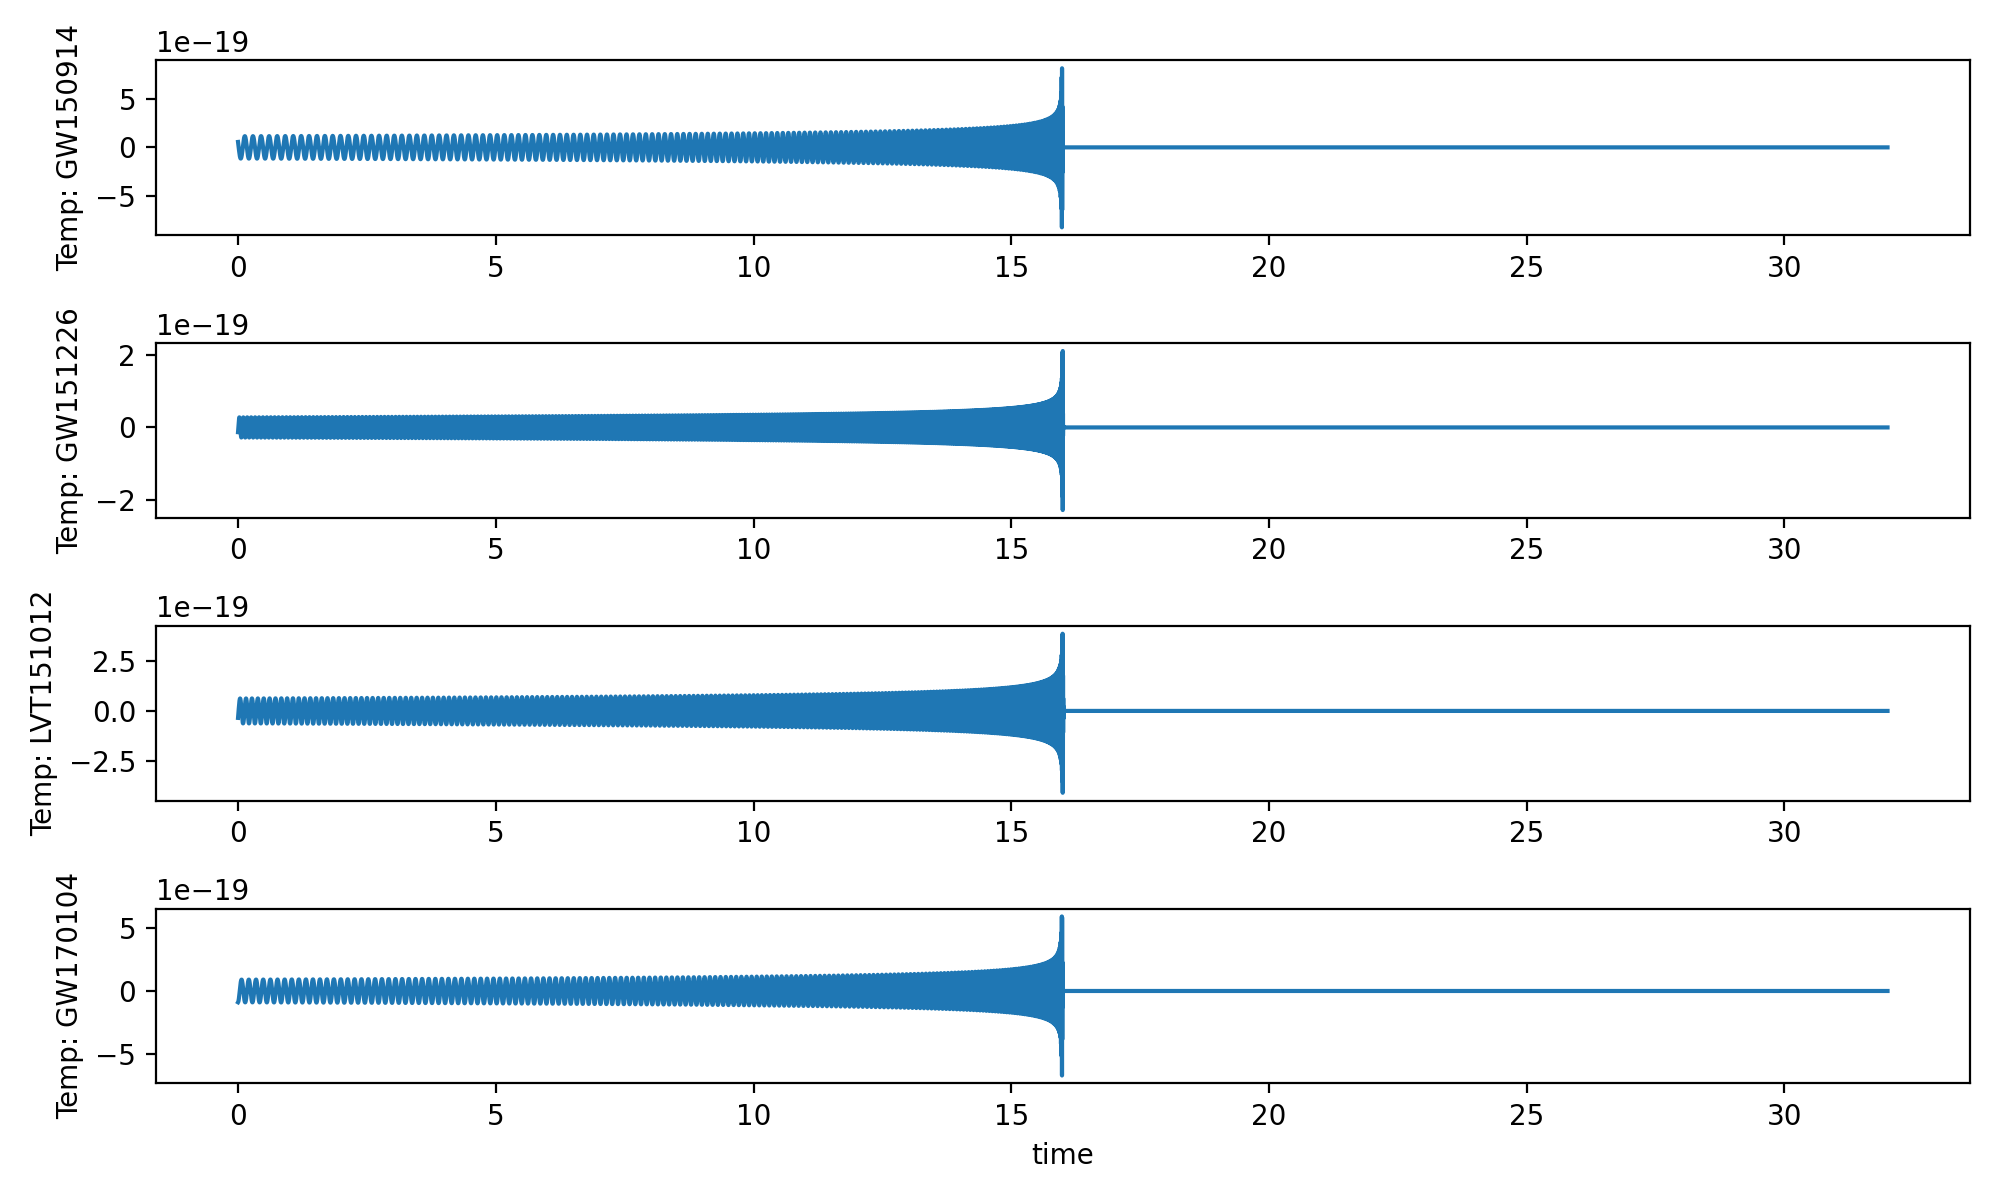

In [13]:
N = len(events[i].strain) #all detectors events have same length and dt (32s)
dt = events[0].dt
freqs = np.fft.rfftfreq(N,dt)
t = np.arange(N)*dt
temp_dict = {0:'Temp: GW150914',1:'Temp: GW151226',2:'Temp: LVT151012',3:'Temp: GW170104'}


#plotting the templates
fig,axs = plt.subplots(len(templates),figsize=(10,10))
for i in range(len(templates)):
    axs[i].plot(t,templates[i].tp)
    axs[i].set_ylabel(temp_dict[i])
axs[-1].set_xlabel('time')
fig.set_size_inches([10,6]) 
fig.tight_layout()

<IPython.core.display.Javascript object>


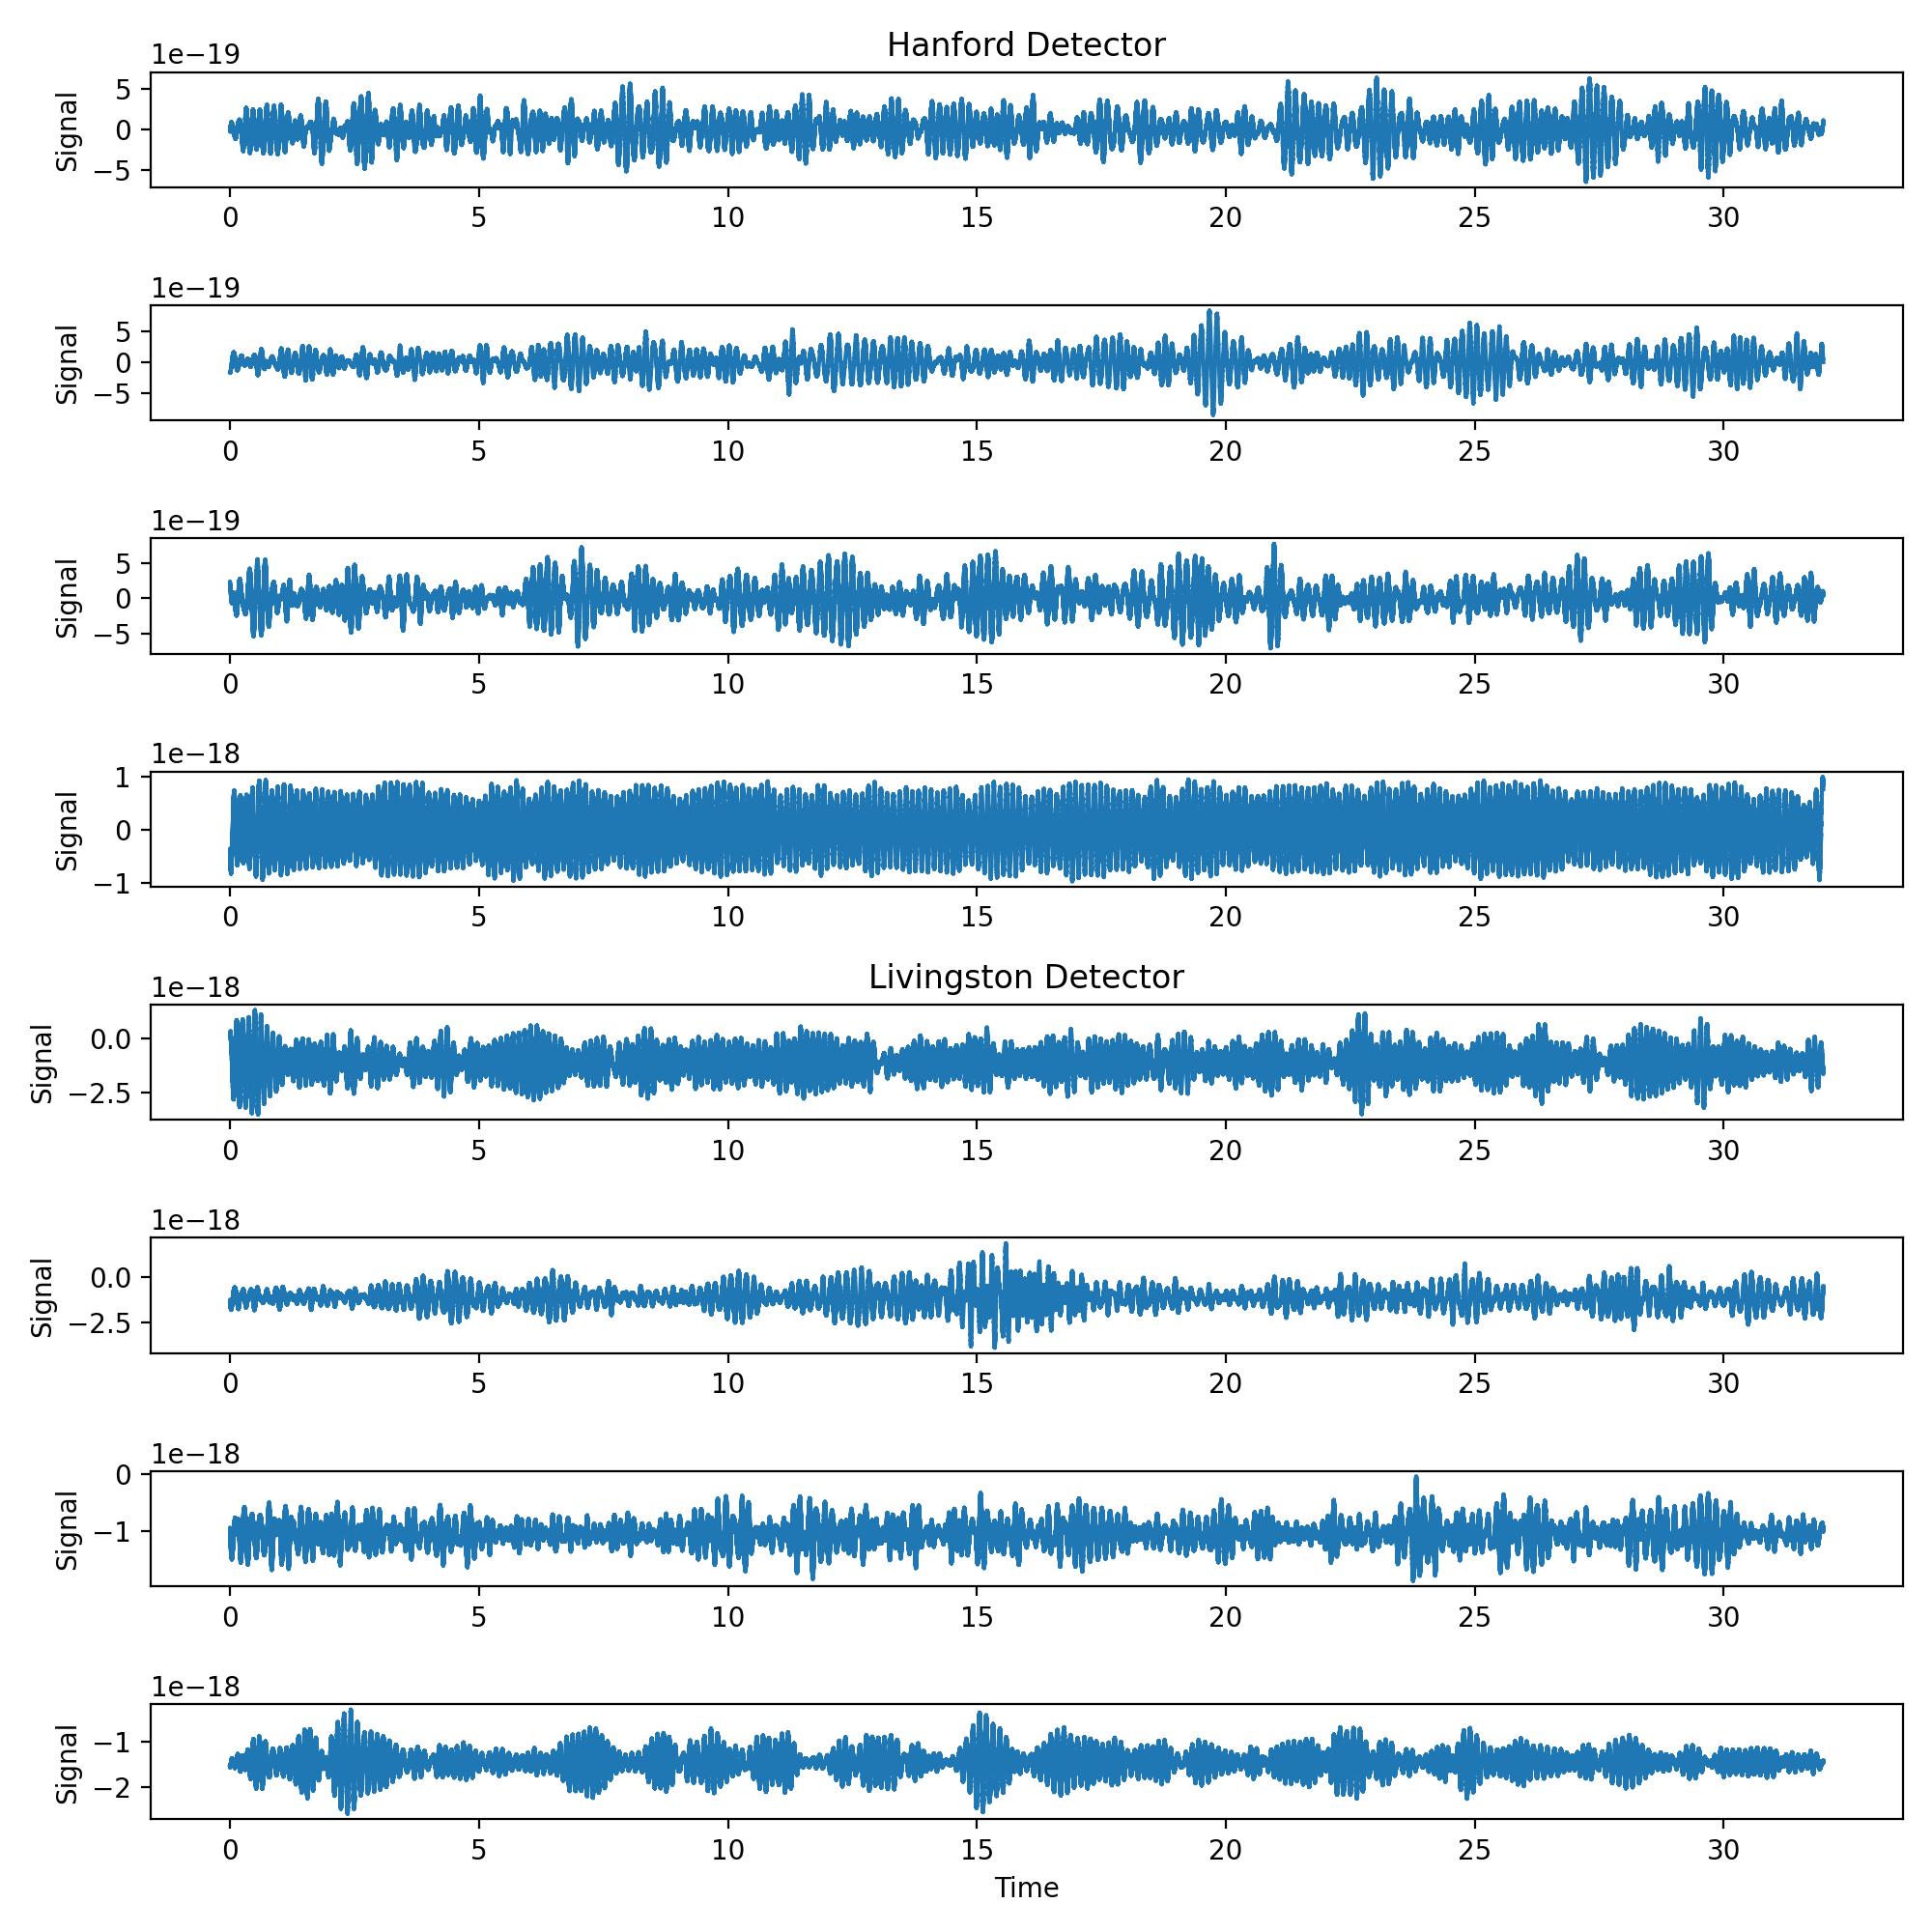

In [14]:
#Look at the untouched strains
fig,axs = plt.subplots(len(events),figsize=(10,16))
for i in range(len(events)):
    axs[i].plot(t,events[i].strain)
    axs[i].set_ylabel('Signal')
axs[0].set_title('Hanford Detector')
axs[4].set_title('Livingston Detector')
axs[-1].set_xlabel('Time')
fig.set_size_inches([10,10]) 
fig.tight_layout()

Indeed, we see that the strains are very noisy (plus not white noise) and that we cannot find a signal out of it. We can look at the strains in frequency space or more particularly at the power spectrum which is given by the absolute value of the fourier transform squared. We use a window, the tukey window when we fourier transform the strains (and also the templates). The tukey window is chosen because it "offers a good (controllable) compromise, in terms of spectral leakage, frequency resolution and amplitude attenuation" (wikipedia) and that it has an extended flat period near the center in order to avoid tapering the data/template where the signal is not small (as suggested in the pset).

## [a]

We first need to come up with a noise model for the Livingston and Hanford detectors. 

Since the strains are so noisy, we can assume that they are all noise and ignore that there is a signal to estimate a noise model. We can use the power spectrum as a "strain-equivalent" noise of the detectors versus frequency (quoting ligo)!

The first adjustment is to use a window to avoid FFT ringing

<IPython.core.display.Javascript object>


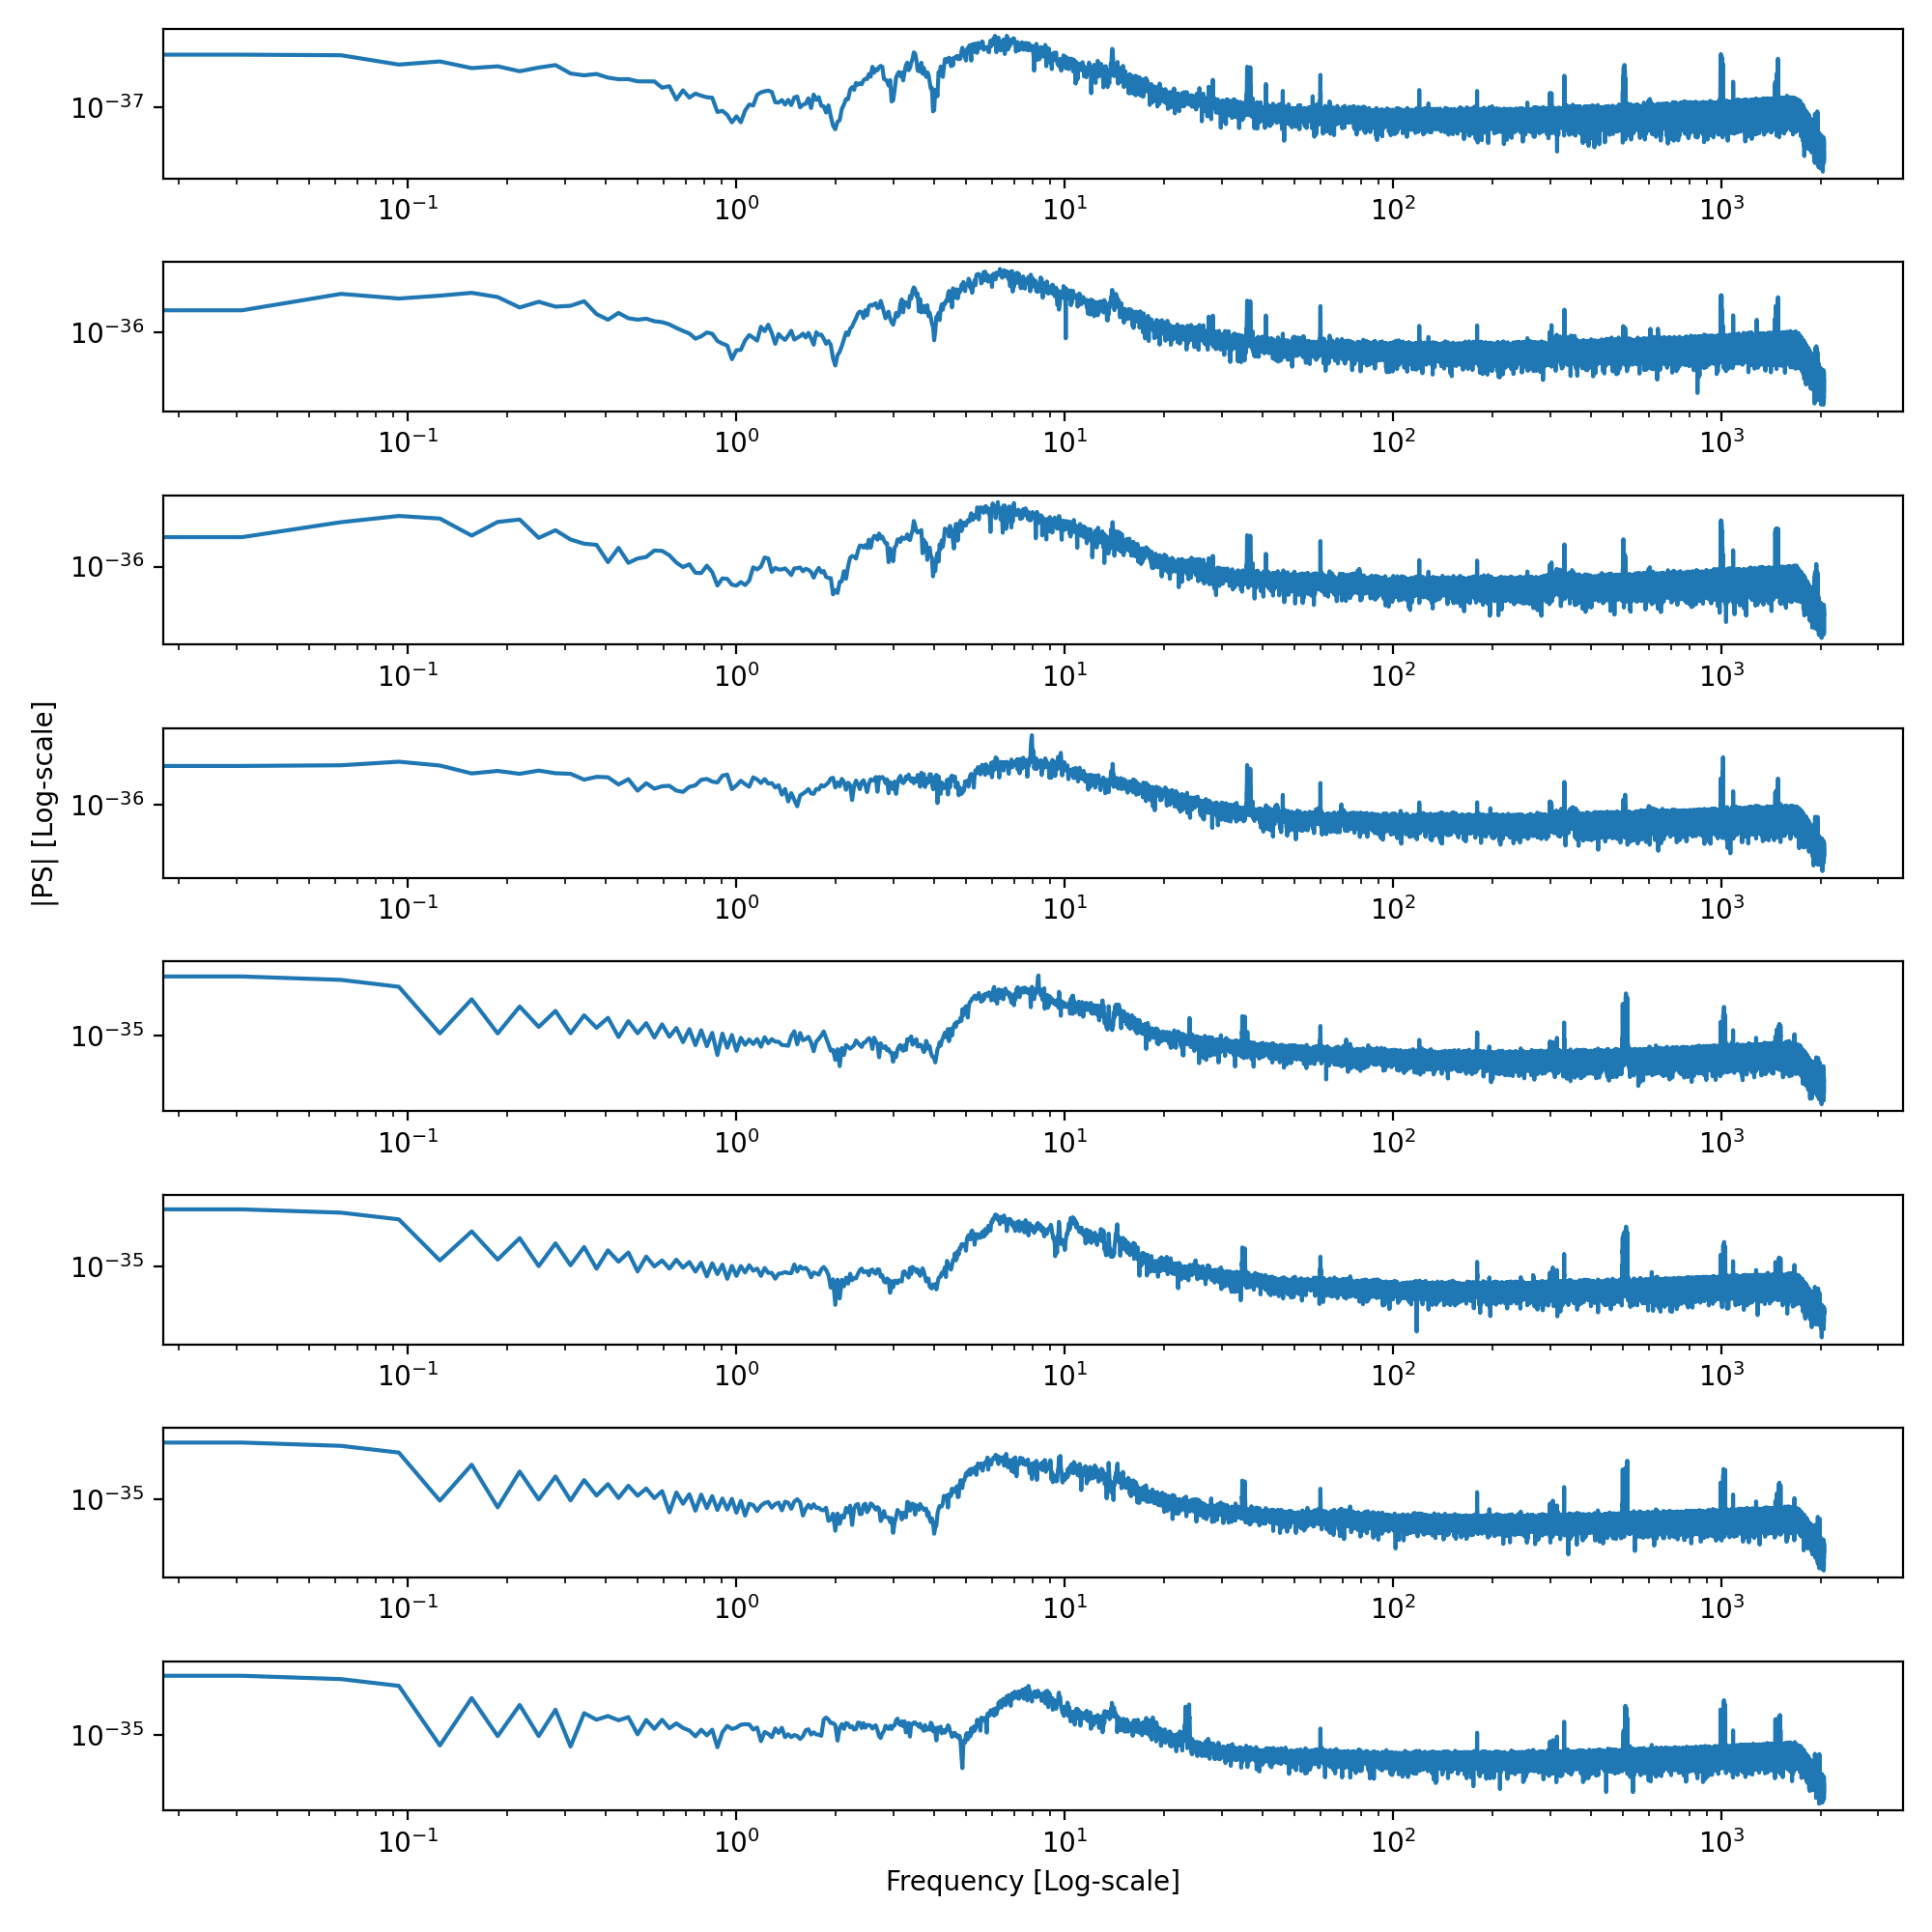

In [15]:
#Look at the powerspectrum for each event
fig,axs = plt.subplots(len(events),figsize=(10,16))
window = signal.windows.tukey(N) #Choose the tukey window

noise_ft = np.zeros((N//2+1,len(events))) 
#estimate the noise in the strains for each event and each detector
for i in range(len(events)):
    noise_ft[:,i] = events[i].get_ps(window) #caculating power spectrum convoluted with window function
    axs[i].loglog(freqs,noise_ft[:,i])
axs[3].set_ylabel('|PS| [Log-scale]')
axs[i].set_xlabel('Frequency [Log-scale]')
fig.set_size_inches([10,10])
fig.tight_layout()

Another adjustment that we make is to smooth out the spectral features (i.e. with the objective of whitening the noise). We can do that by doing a weighted average of neighboor points --> this is the inverse of what problem e) was asking above. In other words, we can simply convolve the noise with a smoothing function given some sigma. We can use a gaussian as it is the most standard method and choose a sigma of 10.

We also take an average of the noise in the events captured by the same dectectors, since we assume they are all just noisy.

<IPython.core.display.Javascript object>


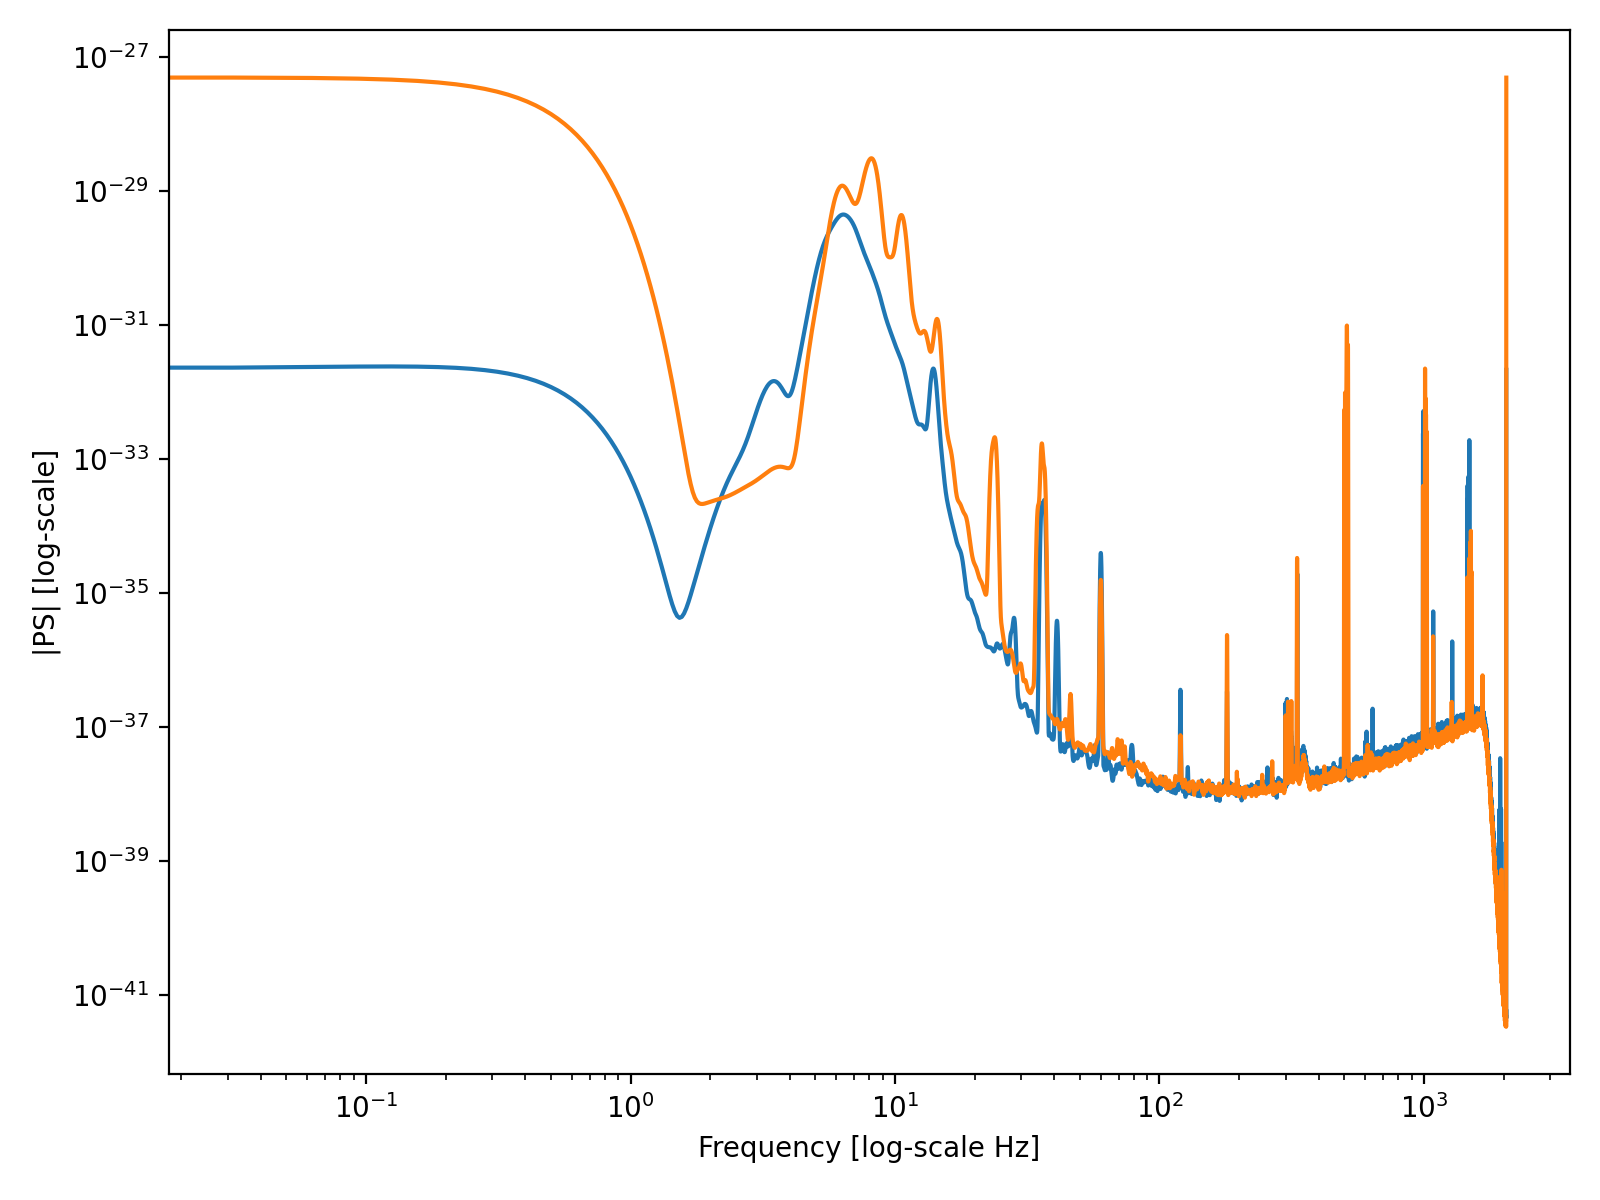

In [16]:
noise_ftH = np.mean(noise_ft[:,:3],axis=1)
noise_ftL = np.mean(noise_ft[:,3:],axis=1)

def smooth_vector(vec,sig): #re-used function of smoothing from Jon's code (changed the fft for rfft since we have
                                    #real signals)
    n=len(vec)
    x=np.arange(n)
    x[n//2:]=x[n//2:]-n
    kernel=np.exp(-0.5*x**2/sig**2) #make a Gaussian kernel
    kernel=kernel/kernel.sum()
    vecft=np.fft.rfft(vec)
    kernelft=np.fft.rfft(kernel)
    vec_smooth=np.fft.irfft(vecft*kernelft) #convolve the data with the kernel
    return vec_smooth

noise_ftH_smooth = smooth_vector(noise_ftH,10) #smoothing Hanford noise model
noise_ftL_smooth = smooth_vector(noise_ftL,10) #smoothing Livingston noise model

#Plot the two models
fig = plt.figure()
plt.loglog(freqs[:-1],noise_ftH_smooth)
plt.loglog(freqs[:-1],noise_ftL_smooth)
plt.xlabel('Frequency [log-scale Hz]')
plt.ylabel('|PS| [log-scale]')
fig.set_size_inches([8,6])
fig.tight_layout()

The final adjustment to make is to delete the unphysical part of the noise (i.e. the very small frequencies and the very large frequencies). As mentioned by Ligo, below frequency of 20Hz, the data are not properly calibrated (plus at such frequency the noise is so high that it is impossible to find a signal) so we discard this frequency region. Because the sample rate is 4096Hz, the detectors cannot detect frequency above that. Ligo chose to cut from frequency higher then 2000Hz but I chose to stick with Jon's code who cut it at 1500Hz.

We also invert it already because it will be used as inverted in the match filter code.

<IPython.core.display.Javascript object>


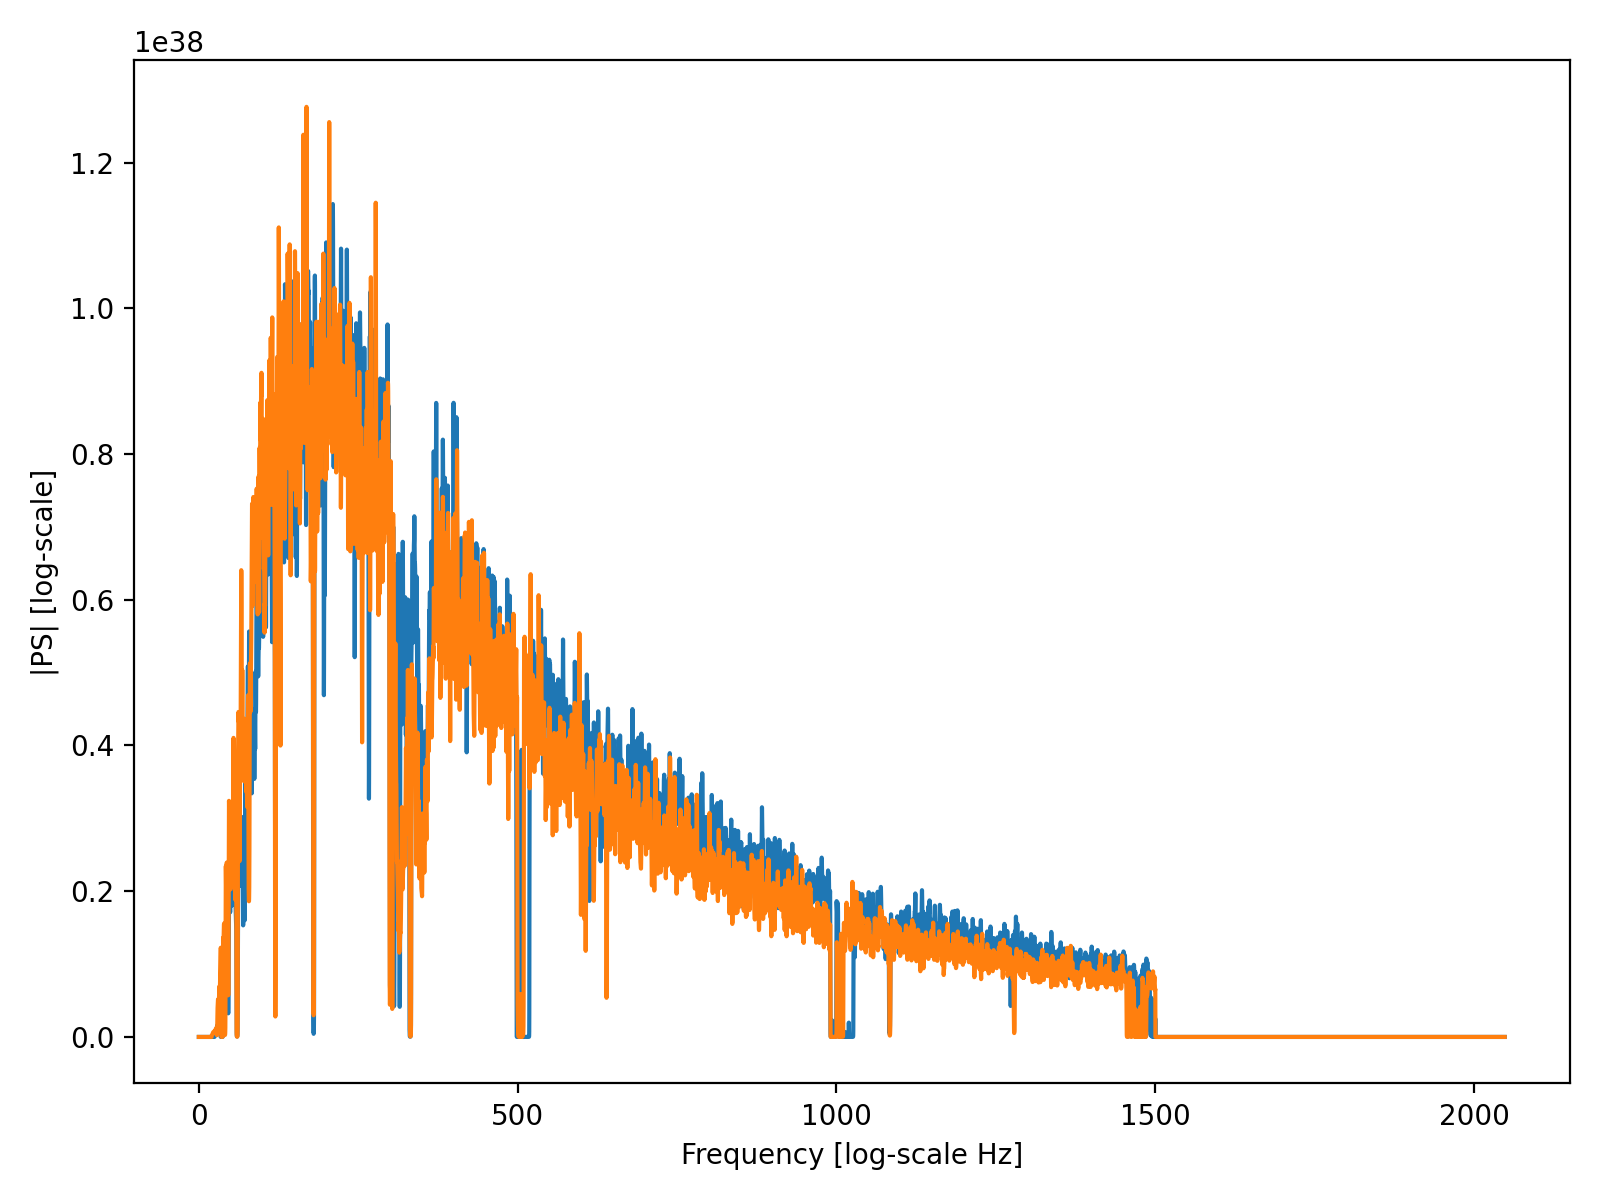

In [17]:
#Re-used Jon's code the cut the unphysical parts of the data
tobs=dt*len(strain)
dnu=1/tobs
nu=np.arange(len(noise_ftH_smooth))*dnu
nu[0]=0.5*nu[1]

NinvH=1/noise_ftH_smooth
NinvH[nu>1500]=0 #delete unphysical part of the noise
NinvH[nu<20]=0
NinvL=1/noise_ftL_smooth
NinvL[nu>1500]=0 #delete unphysical part of the noise
NinvL[nu<20]=0

fig = plt.figure()
plt.plot(freqs[:-1],NinvL)
plt.plot(freqs[:-1],NinvH)
plt.xlabel('Frequency [log-scale Hz]')
plt.ylabel('|PS| [log-scale]')
fig.set_size_inches([8,6])
fig.tight_layout()


## [b] Match Filters

We can now do the match filters for each event since we have the noise model. The method is already explained above.

<IPython.core.display.Javascript object>


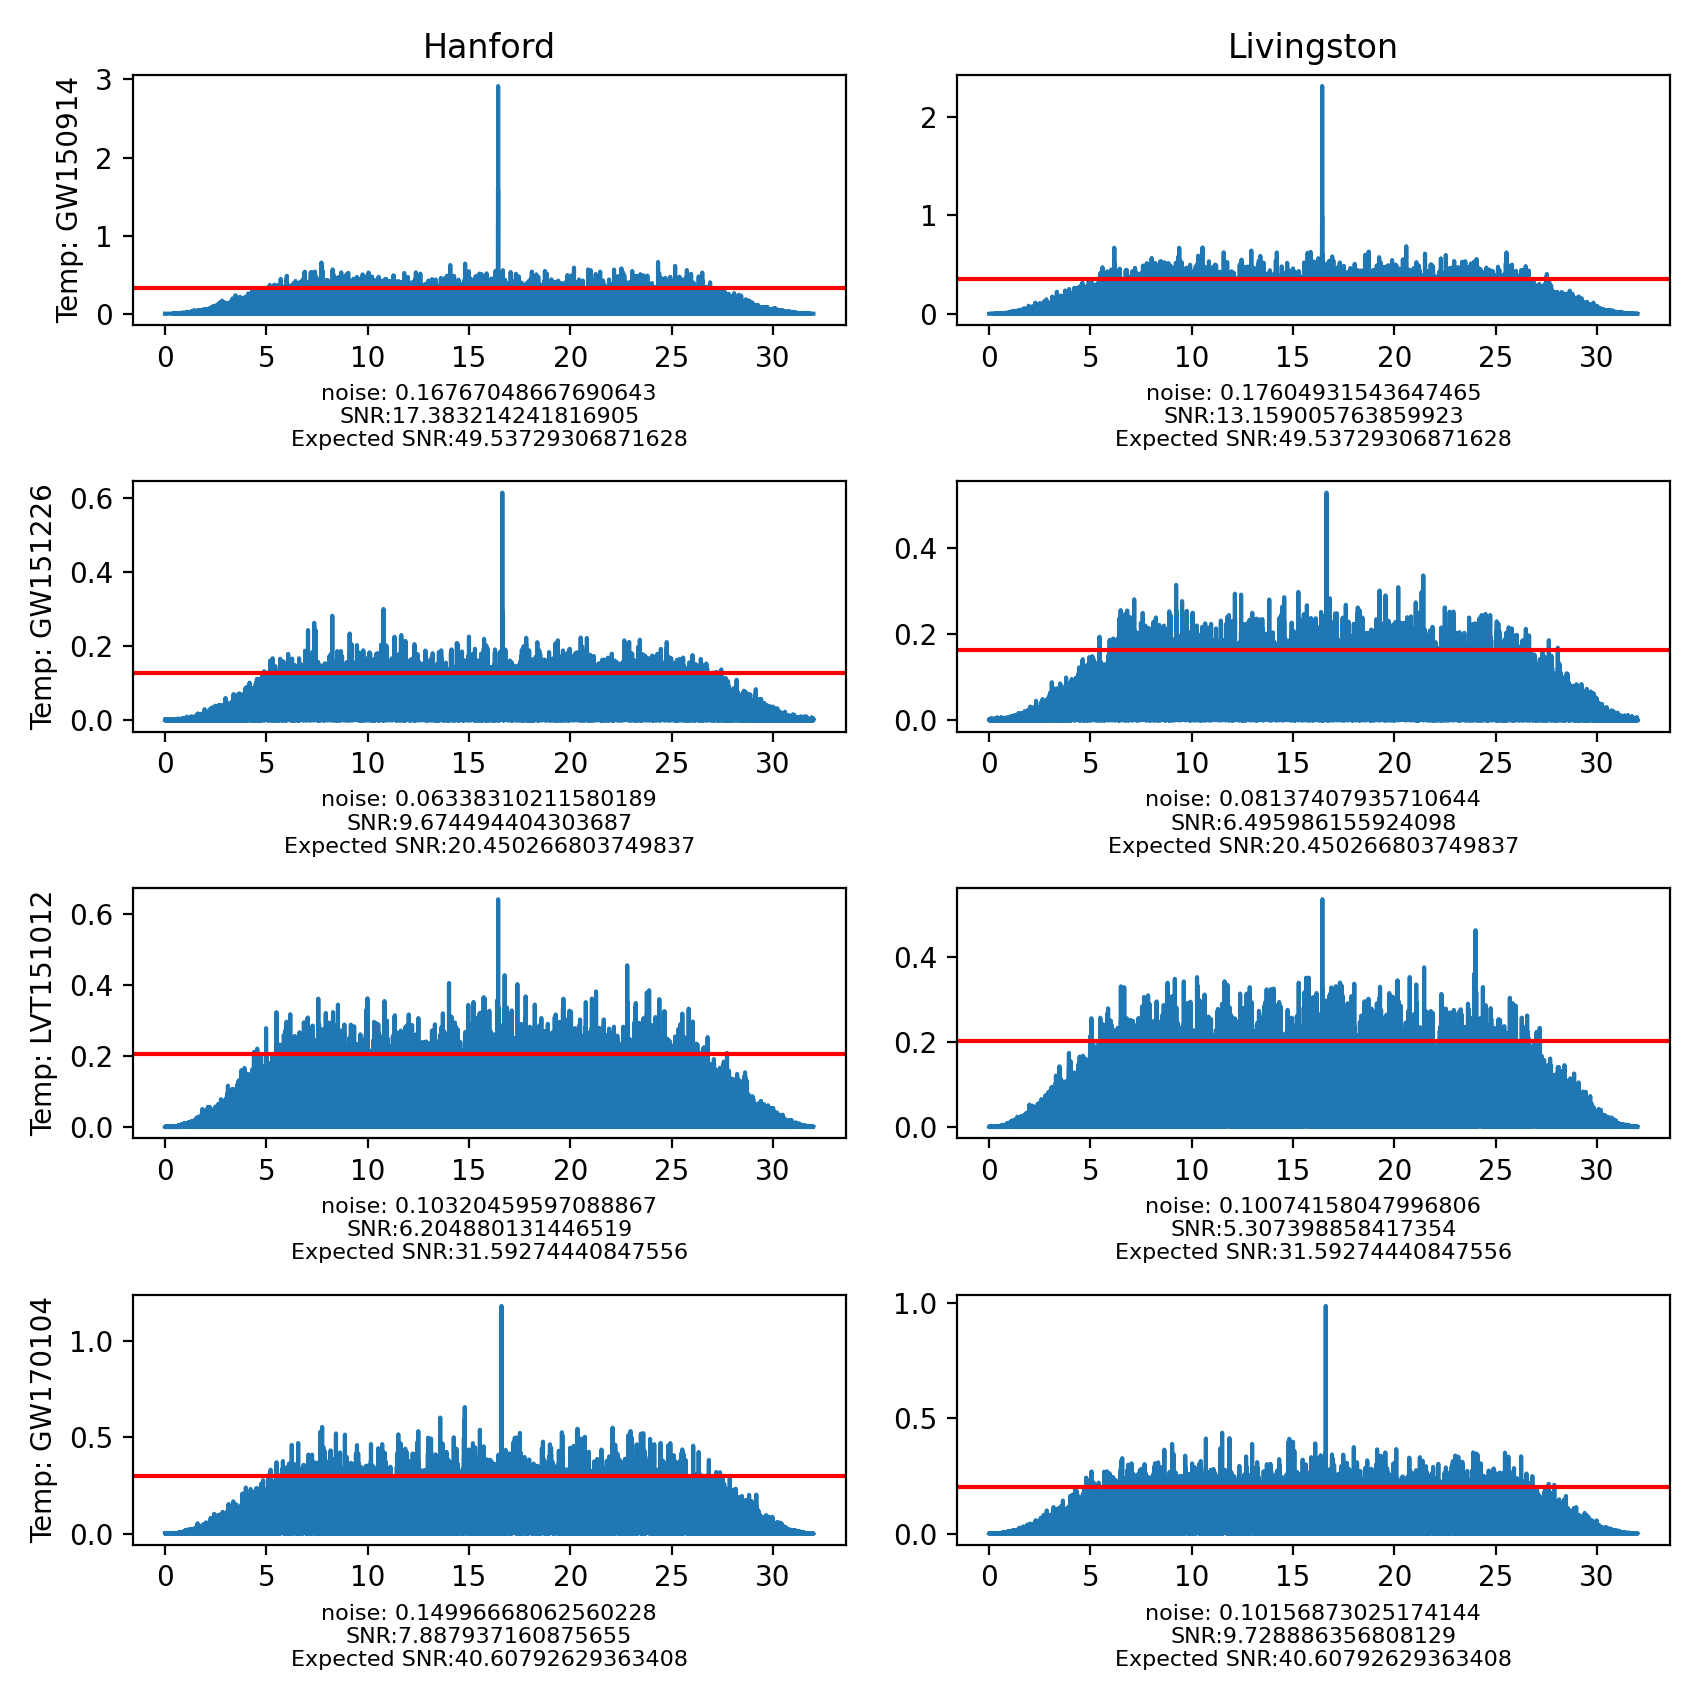

In [18]:
fig,axs = plt.subplots(len(templates),2)

#weird dictionary for matching the right templates
matching_dict = {0:[2,6],1:[0,4],2:[1,5],3:[3,7]} #matching the temp indices with the right events indices


noises = np.zeros(len(events))       #initiate array of the estimated (white) noise of each mf
snrs = np.zeros(len(events))         #initiate array of the snrs for each mf
exp_snrs = np.zeros(len(events))     #initiate array of the exp_snrs for each mf
templates_filtered = np.zeros((len(events),len(NinvH)))    #initiate filtered templates array, since re-used below
tsignals_1sig_H = np.zeros((len(templates),3))         #initiate arrays of the detection time, since re-used below
tsignals_1sig_L = np.zeros((len(templates),3))        

for j in range(len(templates)): #looping over templates
    tp = templates[j].tp
    eventnum = matching_dict[j]
    axs[j,0].set_ylabel(temp_dict[j])
    
    template_ft=np.fft.rfft(tp*window)[:-1] # Fourier transform of the windowed template
    
    for i in range(2): #looping over events per templates (Hanford and Livingston detectors)
        if i==0:
            Ninv = NinvH #first event in eventnum is Hanford
        else:
            Ninv = NinvL #second event in eventnum is Livingston
            
        strain=events[eventnum[i]].strain #get the right strain
        
        template_filt=template_ft*np.sqrt(NinvH) #filter the template by multiplying by sqrt of inv of Noise model
        templates_filtered[2*j+i] = np.abs(template_filt) #store the filtered template
        data_ft=np.fft.rfft(strain*window)[:-1] #Fourier transform of the windowed data
        data_filt = np.sqrt(Ninv)*data_ft #filter the data by multiplying by sqrt of inv of Noise model
        rhs=np.fft.irfft(data_filt*np.conj(template_filt)) #mf formula!
        H = np.max(np.fft.irfft(np.conj(template_filt)*template_filt)) #Hessian formula which is just a constant
        mf = rhs #not caring about the amplitude
        mf_shift = np.fft.fftshift(mf)
                
        axs[j,i].plot(t[1:-1],np.abs(mf_shift))
        
        noises[2*j+i]= np.std(mf_shift[len(mf)//4:-len(mf)//4]) #estimate the white noise as the std of mf 
                                                                    #but cut where the "window is visible"
        snrs[2*j+i] = np.max(np.abs(mf))/noises[2*j+i] #snr is the amplitude of the signal over the noise
        exp_snrs[2*j+i] = np.sqrt(H) #formula for the expected SNR
        
        axs[j,i].axhline(2*noises[2*j+i],color='r')
        axs[j,i].set_xlabel('noise: {}\nSNR:{}\nExpected SNR:{}'.format(noises[2*j+i],snrs[2*j+i],exp_snrs[2*j+i]),fontsize=8)
        
        #computing the detection time
        idx_signal = np.where(np.abs(mf_shift) == np.max(np.abs(mf_shift)))[0][0]
        idx_left = np.abs(np.abs(mf_shift[:idx_signal]) - (np.max(np.abs(mf_shift))-noises[2*j+i])).argmin()
        idx_right = idx_signal+np.abs(np.abs(mf_shift[idx_signal:]) - (np.max(np.abs(mf_shift))-noises[2*j+i])).argmin()
        if i==0:
            tsignals_1sig_H[j,0]=t[idx_left]
            tsignals_1sig_H[j,1]=t[idx_signal]
            tsignals_1sig_H[j,2]=t[idx_right]
        else:
            tsignals_1sig_L[j,0]=t[idx_left]
            tsignals_1sig_L[j,1]=t[idx_signal]
            tsignals_1sig_L[j,2]=t[idx_right]            
        

        
axs[0,0].set_title('Hanford')
axs[0,1].set_title('Livingston')
fig.set_size_inches(8.5,8.5)
fig.tight_layout()



## [c]

If we now assume that the noise is white in our match filters, we can simply take the standard deviation of the match filter to estimate the noise. (See the results in the plot above)

The signal to noise ratio is given by the amplitude of our signal over the noise estimate. See the results in the plot above. (See the results in the plot above)

## [d]

The Hessian is given by $(N^{-1/2}A((t-\tau))^T*(N^{-1/2}A((t-\tau))$ as derived above and we can rewrite it with white noise as $\text{conj(}A_{\text{filtered}}(t-\tau))A_{\text{filtered}}(t-\tau)$ which again is a correlation and we can compute it in Fourier space using windows.

Thus we can use the derivation for the ideal SNR for our template with white noise which is given by $\sqrt{(A^T A)} = \sqrt{H}$. This is what is computed in the code. 


In [19]:
for i in range(len(events)//2):
    print('Event with',temp_dict[i])
    print('SNR combined: {}'.format(0.5*(snrs[2*i]+snrs[2*i+1])))
    print('SNR ideal combined: {}\n\n'.format(0.5*(exp_snrs[2*i]+exp_snrs[2*i+1])))

Event with Temp: GW150914
SNR combined: 15.271110002838414
SNR ideal combined: 49.53729306871628


Event with Temp: GW151226
SNR combined: 8.085240280113892
SNR ideal combined: 20.450266803749837


Event with Temp: LVT151012
SNR combined: 5.756139494931936
SNR ideal combined: 31.59274440847556


Event with Temp: GW170104
SNR combined: 8.808411758841892
SNR ideal combined: 40.60792629363408




Obviously, the ideal SNRs are higher than our obtained SNRs since we can never have match filter as good as the template!

## [e]
We want to estimate the frequency of each event and from each detector. The filtered templates (i.e. pre-whitened with our noise model) in fourier space give the power spectrum of the signal which give an insight of which frequency best describe the data. If we take a cumulative sum of the power spectrum as a function of frequency, we are "adding" the information of what the signal should look like. The frequency which matches the middle of the cumulative sum represents the frequency at which half the power comes from above and half the power comes from below.

<IPython.core.display.Javascript object>


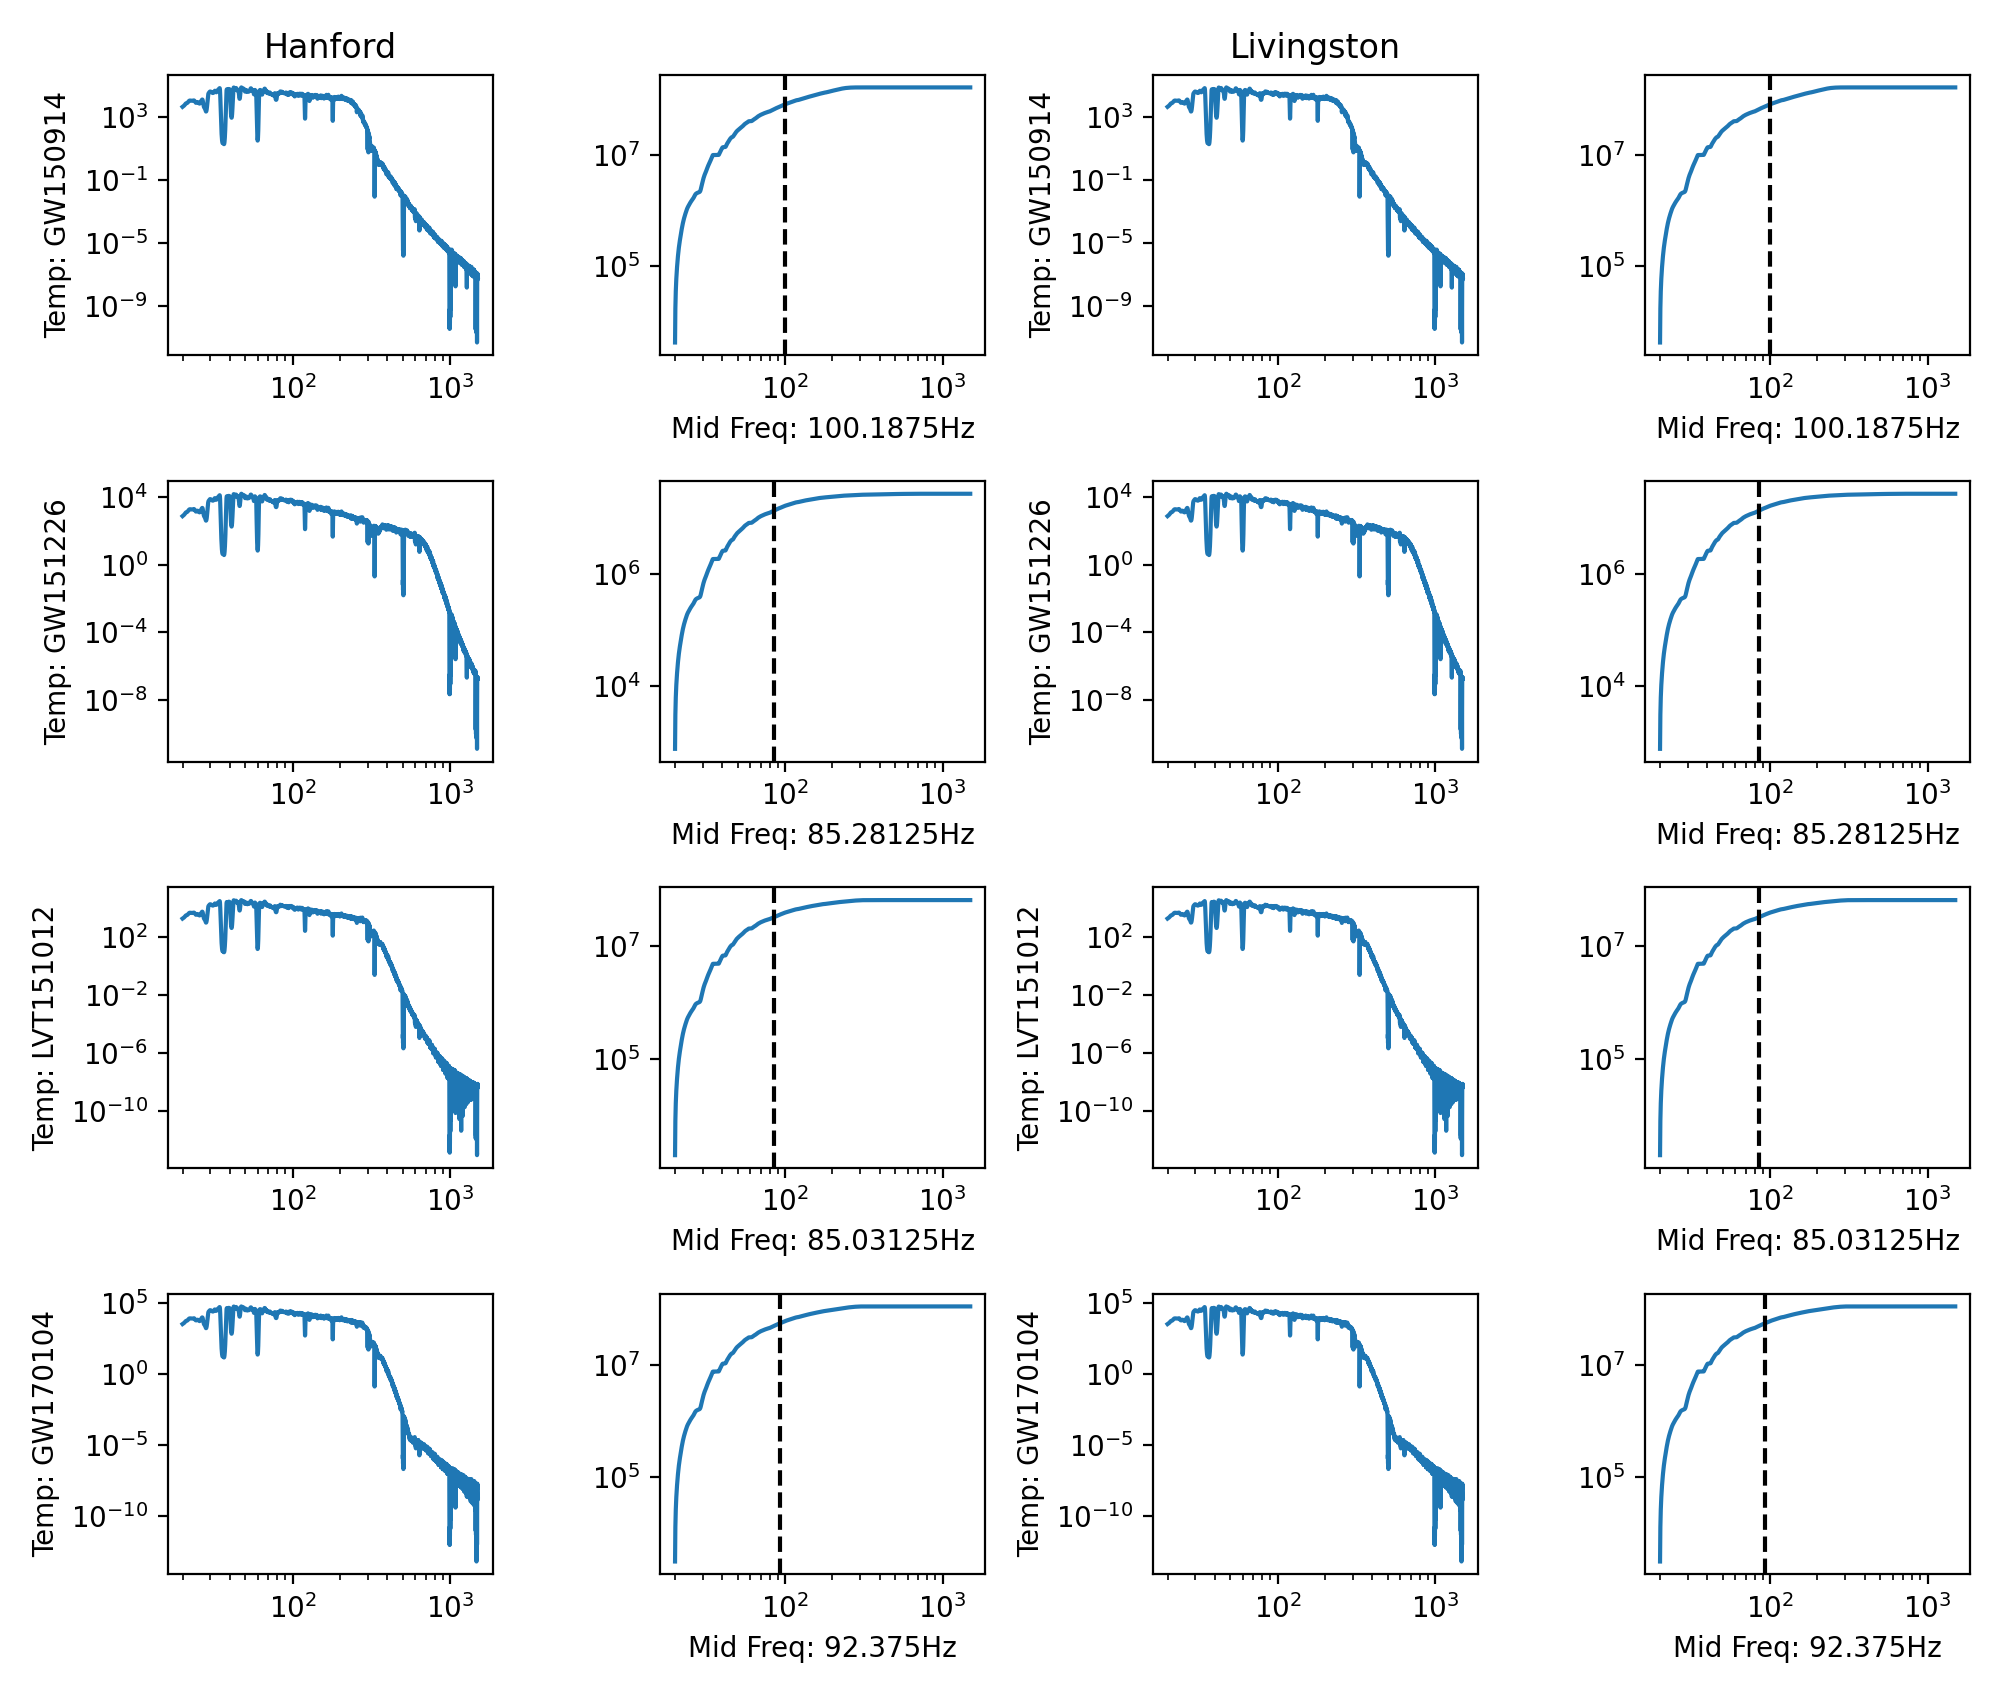

In [20]:
fig,axs = plt.subplots(len(templates),4)
mid_freqs = np.zeros(len(templates)) #initialize array of mid frequencies
for i in range(len(templates)):
    temp = templates[i].tp
    axs[0,0].set_title('Hanford')
    axs[0,2].set_title('Livingston')
    for j in range(2):
        temp_filt = templates_filtered[2*i+j] #filtered templates which were already computed 
        pws = np.abs(temp_filt)**2 #power spectrum of the pre-whitened templates
        cum_pws = np.cumsum(pws) #cumulative sum
        pws2 = pws[pws!=0]
        freqs_temp = freqs[:-1]
        freqs2 = freqs_temp[pws!=0]
        axs[i,2*j].loglog(freqs2,pws2)
        axs[i,2*j].set_ylabel(temp_dict[i])
        axs[i,2*j+1].loglog(freqs2,cum_pws[pws!=0])
        mid_pws = cum_pws[-1]/2 #half of cumulative sum
        mid_freq = freqs[np.abs(cum_pws - mid_pws).argmin()] #find matching frequency of half cumulative sum
        axs[i,2*j+1].set_xlabel('Mid Freq: {}Hz'.format(mid_freq))
        axs[i,2*j+1].axvline(mid_freq,linestyle='--', color='k')

    
        
fig.set_size_inches(10,8.5)
fig.tight_layout()


## [f]

We want to find the position and its uncertainty of the gravitational wave given that the detectors are a few thousands of kilometers apart. This can be inferred from the time difference of the detectors and their respective uncertainty. 

With some trigonometry, we have that the angle at which we received the signal is given by 

$\theta = sin^{-1}\left(\frac{c\Delta t}{D}\right)$ 

where $\Delta t = |t_H - t_L|$, $D$ is the distance between the two detectors (i.e. a few thousands of kilometers) and $c$ is the speed of light. Then, by error propagation, we have the uncertainty on the position ($\theta$) is

$\sigma_\theta = \frac{c\sigma_{\Delta t}}{D}\frac{1}{\sqrt{1-\left(\frac{c\Delta t}{D}\right)^2}}$

We get the uncertainty $\sigma_{\Delta t}$ by taking the average of $t_{\text{signal}}-t_{\text{signal+sigma}}$ and $t_{\text{signal}}-t_{\text{signal-sigma}}$, where $t_{\text{signal±sigma}}$ is the time at ± one $\sigma$ of max signal of the match filter.

In [21]:
#The signal times were computed above where the match filters were plotted
sig_H = np.zeros(len(tsignals_1sig_H))
sig_L = np.zeros(len(tsignals_1sig_H))
dts = np.zeros(len(tsignals_1sig_H))
for i in range(len(tsignals_1sig_H)):
    sig_H[i] = np.mean((tsignals_1sig_H[i,1]-tsignals_1sig_H[i,0],tsignals_1sig_H[i,2]-tsignals_1sig_H[i,1]))
    sig_L[i] = np.mean((tsignals_1sig_L[i,1]-tsignals_1sig_L[i,0],tsignals_1sig_L[i,2]-tsignals_1sig_L[i,1]))
    dts[i] = np.abs(tsignals_1sig_H[i,1]-tsignals_1sig_L[i,1])

dts = np.mean(dts[i])
#something weird happened and I did not have time to fix it so I decided to just discard an output
sig_H = np.mean(sig_H)
sig_L = np.mean((sig_L[0],sig_L[1],sig_L[3]))
dts_err = np.sqrt(sig_H**2+sig_L**2)
print('The time delay between the two detectors is {} ± {} s'.format(f'{dts:.3}',f'{dts_err:.2}'))

The time delay between the two detectors is 0.00317 ± 0.00078 s


In [22]:
#compute the position
c=3e8
D=1e6
def arcsin_deriv(x):
    return (1-x**2)**(-0.5)

angle_uncertainty = dts_err*c/D*arcsin_deriv(c*dts/D)
print('The typical positional uncertainty is about {} rad'.format(f'{angle_uncertainty:.1}'))
angle_uncertainty

The typical positional uncertainty is about 0.8 rad


0.7703951248916892